### Motivation: 

To understand Logistic Regression and Decision Trees and explore these algorthims using Sklearn, Statmodel, ROC-AUC curve, Precision curve, Sequential feature selection, Hyperparamter tuning and Post pruning.

### Problem Statement:

1. To predict whether a liability customer will buy a personal loan or not
2. Which variables are the most significant
3. Which segment of customers should be targeted more
4. Does age have any impact on the customer borrowing a loan or not
5. Do people with less income borrow loans

In [6]:
# Importing libraries

import scipy.stats as stats
import pandas as pd
import numpy as np
import zipcodes as zcodes

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [7]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 400)

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [8]:
df = pd.read_csv('Bank_Personal_Loan_Modeling.csv')
df_loan = df.copy()
print(f'There are {df_loan.shape[0]} rows and {df_loan.shape[1]} columns')

There are 5000 rows and 14 columns


In [9]:
df_loan.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.600,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.500,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.000,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.700,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.000,2,0,0,0,0,0,1


In [10]:
print('Rows: ', df_loan.shape[0])
print('Columns: ', df_loan.shape[1])

print('\n', '#' *40, '\n', 'Features: \n\n', df_loan.columns.tolist())
print('\n', '#' *40, '\n', 'Missing values: \n\n', df_loan.isnull().sum().sort_values(ascending = False))
print('\n', '#' *40, '\n', 'Percentage of missing values: \n\n', round((df_loan.isna().sum() / df.isna().count()) * 100, 2))
print('\n', '#' *40, '\n', 'Unique values: \n\n', df_loan.nunique())

Rows:  5000
Columns:  14

 ######################################## 
 Features: 

 ['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg', 'Education', 'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

 ######################################## 
 Missing values: 

 ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

 ######################################## 
 Percentage of missing values: 

 ID                   0.000
Age                  0.000
Experience           0.000
Income               0.000
ZIP Code             0.000
Family               0.000
CCAvg                0.000
Education            0.000
Mortgage             0.000
Personal Loa

In [11]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


#### Inference:

1. There are no missing values in the dataset.
2. All the columns are numerical.
3. Personal loan is the target variable.
4. ZIP code, Family, Education, Securities account, CD account, Online, Credit card are all categorical variables.

In [12]:
# ID coliumn is not needed and can be dropped

df_loan.drop('ID', axis = 1, inplace = True)

### Data Preprocessing

Processing ZIP code: ZIP code is a categorical variable and can be a good predictor of the target variable. We could analyse if there exists any pattern about the location of customers who had borrowed a loan during the previous campaign. Lets see if we can reduce the number of categories.

In [13]:
df_loan.rename(columns = {'ZIP Code': 'ZIPCode', 'Personal Loan': 'PersonalLoan', 'Securities Account': 'SecuritiesAccount', 
                         'CD Account': 'CDAccount'}, inplace = True)

In [14]:
df_loan.ZIPCode.nunique()
list_zipcode = df_loan.ZIPCode.unique()

In [15]:
dict_zip = {}
for zipcode in list_zipcode:
    my_city_county = zcodes.matching(zipcode.astype('str'))
    if len(my_city_county) == 1:
        county = my_city_county[0].get('county')
    else:
        county = zipcode
    dict_zip.update({zipcode: county})       

#### Inference:

We got the respective counties for almost every zipcode except for: 96651, 92634, 93077, 92717. We can fix this by searching for their counties on the internet.

In [16]:
dict_zip.update({92717: 'Orange County'})
dict_zip.update({92634: 'Orange County'})

In [17]:
df_loan['County'] = df_loan['ZIPCode'].map(dict_zip)

In [18]:
df_loan['County'].nunique()

40

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


### Fixing the data types:

PersonalLoan, SecuritiesAccount, CDAccount, Online, CreditCard, Education are of int/object type. We can change them to category type to reduce the dataspace required.

In [20]:
# Converting categorical variables to category type

category_col = ['PersonalLoan', 'SecuritiesAccount', 'Family', 'CDAccount', 'Online', 'CreditCard', 'ZIPCode', 'Education', 'County']
df_loan[category_col] = df_loan[category_col].astype('category')

In [21]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                5000 non-null   int64   
 1   Experience         5000 non-null   int64   
 2   Income             5000 non-null   int64   
 3   ZIPCode            5000 non-null   category
 4   Family             5000 non-null   category
 5   CCAvg              5000 non-null   float64 
 6   Education          5000 non-null   category
 7   Mortgage           5000 non-null   int64   
 8   PersonalLoan       5000 non-null   category
 9   SecuritiesAccount  5000 non-null   category
 10  CDAccount          5000 non-null   category
 11  Online             5000 non-null   category
 12  CreditCard         5000 non-null   category
 13  County             5000 non-null   category
dtypes: category(9), float64(1), int64(4)
memory usage: 266.4 KB


In [22]:
# Checking negative and zero values for the Experience column
# 52 customers from age 23 to 29 have negative values in experience

df_loan[df_loan['Experience'] < 0]['Age'].describe()

count   52.000
mean    24.519
std      1.475
min     23.000
25%     24.000
50%     24.000
75%     25.000
max     29.000
Name: Age, dtype: float64

In [23]:
df_loan[df_loan['Experience'] < 0].sort_values(by = 'Experience', ascending = True)

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,County
4514,24,-3,41,91768,4,1.000,3,0,0,0,0,1,0,Los Angeles County
2618,23,-3,55,92704,3,2.400,2,145,0,0,0,1,0,Orange County
4285,23,-3,149,93555,2,7.200,1,0,0,0,0,1,0,Kern County
3626,24,-3,28,90089,4,1.000,3,0,0,0,0,0,0,Los Angeles County
2717,23,-2,45,95422,4,0.600,2,0,0,0,0,1,1,Lake County
2876,24,-2,80,91107,2,1.600,3,238,0,0,0,0,0,Los Angeles County
3130,23,-2,82,92152,2,1.800,2,0,0,1,0,0,1,San Diego County
2466,24,-2,80,94105,2,1.600,3,0,0,0,0,1,0,San Francisco County
3796,24,-2,50,94920,3,2.400,2,0,0,1,0,0,0,Marin County
2962,23,-2,81,91711,2,1.800,2,0,0,0,0,0,0,Los Angeles County


In [24]:
df_loan.groupby(['Age', 'Experience'])['Experience'].describe()

count   mean   std    min    25%    50%    75%    max
Age Experience                                                       
23  -3          2.000 -3.000 0.000 -3.000 -3.000 -3.000 -3.000 -3.000
    -2          4.000 -2.000 0.000 -2.000 -2.000 -2.000 -2.000 -2.000
    -1          6.000 -1.000 0.000 -1.000 -1.000 -1.000 -1.000 -1.000
24  -3          2.000 -3.000 0.000 -3.000 -3.000 -3.000 -3.000 -3.000
    -2          9.000 -2.000 0.000 -2.000 -2.000 -2.000 -2.000 -2.000
    -1          6.000 -1.000 0.000 -1.000 -1.000 -1.000 -1.000 -1.000
     0         11.000  0.000 0.000  0.000  0.000  0.000  0.000  0.000
25  -2          1.000 -2.000   NaN -2.000 -2.000 -2.000 -2.000 -2.000
    -1         17.000 -1.000 0.000 -1.000 -1.000 -1.000 -1.000 -1.000
     0         17.000  0.000 0.000  0.000  0.000  0.000  0.000  0.000
     1         18.000  1.000 0.000  1.000  1.000  1.000  1.000  1.000
26  -1          1.000 -1.000   NaN -1.000 -1.000 -1.000 -1.000 -1.000
     0         28.000  0.000 0.000  0.000  0.000  0.000  0.000  0.000
     1         22.000  1.000 0.000  1.000  1.000  1.000  1.000  1.000
     2         27.000  2.000 0.000  2.000  2.000  2.000  2.000  2.000
27   0          8.000  0.000 0.000  0.000  0.000  0.000  0.000  0.000
     1         27.000  1.000 0.000  1.000  1.000  1.000  1.000  1.000
     2         20.000  2.000 0.000  2.000  2.000  2.000  2.000  2.000
     3         36.000  3.000 0.000  3.000  3.000  3.000  3.000  3.000
28  -2          1.000 -2.000   NaN -2.000 -2.000 -2.000 -2.000 -2.000
     1          2.000  1.000 0.000  1.000  1.000  1.000  1.000  1.000
     2         29.000  2.000 0.000  2.000  2.000  2.000  2.000  2.000
     3         37.000  3.000 0.000  3.000  3.000  3.000  3.000  3.000
     4         34.000  4.000 0.000  4.000  4.000  4.000  4.000  4.000
29  -1          3.000 -1.000 0.000 -1.000 -1.000 -1.000 -1.000 -1.000
     0          1.000  0.000   NaN  0.000  0.000  0.000  0.000  0.000
     2          7.000  2.000 0.000  2.000  2.000  2.000  2.000  2.000
     3         44.000  3.000 0.000  3.000  3.000  3.000  3.000  3.000
     4         26.000  4.000 0.000  4.000  4.000  4.000  4.000  4.000
     5         42.000  5.000 0.000  5.000  5.000  5.000  5.000  5.000
30   0          1.000  0.000   NaN  0.000  0.000  0.000  0.000  0.000
     3          7.000  3.000 0.000  3.000  3.000  3.000  3.000  3.000
     4         44.000  4.000 0.000  4.000  4.000  4.000  4.000  4.000
     5         40.000  5.000 0.000  5.000  5.000  5.000  5.000  5.000
     6         44.000  6.000 0.000  6.000  6.000  6.000  6.000  6.000
31   1          5.000  1.000 0.000  1.000  1.000  1.000  1.000  1.000
     4          7.000  4.000 0.000  4.000  4.000  4.000  4.000  4.000
     5         54.000  5.000 0.000  5.000  5.000  5.000  5.000  5.000
     6         22.000  6.000 0.000  6.000  6.000  6.000  6.000  6.000
     7         37.000  7.000 0.000  7.000  7.000  7.000  7.000  7.000
32   2          2.000  2.000 0.000  2.000  2.000  2.000  2.000  2.000
     5          3.000  5.000 0.000  5.000  5.000  5.000  5.000  5.000
     6         39.000  6.000 0.000  6.000  6.000  6.000  6.000  6.000
     7         39.000  7.000 0.000  7.000  7.000  7.000  7.000  7.000
     8         37.000  8.000 0.000  8.000  8.000  8.000  8.000  8.000
33   3          5.000  3.000 0.000  3.000  3.000  3.000  3.000  3.000
     6          7.000  6.000 0.000  6.000  6.000  6.000  6.000  6.000
     7         41.000  7.000 0.000  7.000  7.000  7.000  7.000  7.000
     8         30.000  8.000 0.000  8.000  8.000  8.000  8.000  8.000
     9         37.000  9.000 0.000  9.000  9.000  9.000  9.000  9.000
34   4          2.000  4.000 0.000  4.000  4.000  4.000  4.000  4.000
     7          2.000  7.000 0.000  7.000  7.000  7.000  7.000  7.000
     8         36.000  8.000 0.000  8.000  8.000  8.000  8.000  8.000
     9         53.000  9.000 0.000  9.000  9.000  9.000  9.000  9.000
     10        41.000 10.000 0.000 10.000 10.000 10.000 10.000 10.000
35   5          7.000  5.0

It seems that the experience is negative for all observations with age 23, 24 and a few others. Based on their age and education, it seems that the values were negative by mistake. So, changing it to absolute values of experience.

In [25]:
df_loan.loc[df_loan['Experience'] < 0, 'Experience'] = np.abs(df_loan['Experience'])

In [26]:
df_loan[df_loan['Experience'] == 0]['Age'].describe()

count   66.000
mean    25.636
std      1.145
min     24.000
25%     25.000
50%     26.000
75%     26.000
max     30.000
Name: Age, dtype: float64

Upon checking the age and the income of these customers with an experience of 0 years; we will see as to how we can modify this column after more EDA.

### Exploratory Data Analysis

In [27]:
df_loan.describe()

,Age,Experience,Income,CCAvg,Mortgage
count,5000.000,5000.000,5000.000,5000.000,5000.000
mean,45.338,20.135,73.774,1.938,56.499
std,11.463,11.415,46.034,1.748,101.714
min,23.000,0.000,8.000,0.000,0.000
25%,35.000,10.000,39.000,0.700,0.000
50%,45.000,20.000,64.000,1.500,0.000
75%,55.000,30.000,98.000,2.500,101.000
max,67.000,43.000,224.000,10.000,635.000


In [28]:
for col in category_col:
    print(df_loan[col].value_counts())
    print("#"*40)

0    4520
1     480
Name: PersonalLoan, dtype: int64
########################################
0    4478
1     522
Name: SecuritiesAccount, dtype: int64
########################################
1    1472
2    1296
4    1222
3    1010
Name: Family, dtype: int64
########################################
0    4698
1     302
Name: CDAccount, dtype: int64
########################################
1    2984
0    2016
Name: Online, dtype: int64
########################################
0    3530
1    1470
Name: CreditCard, dtype: int64
########################################
94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
94087      1
90813      1
94404      1
90068      1
9307       1
Name: ZIPCode, Length: 467, dtype: int64
########################################
1    2096
3    1501
2    1403
Name: Education, dtype: int64
########################################
Los Angeles County        1095
San Diego County           568
Santa Clara County         563
Alameda C

#### Notes:

1. Need to verify the maximum salary (224k USD).
2. Need to verify the maximum mortgage amount (635k USD).
3. Average spending on credit cards per month ranges from 1k to 10k; with a mean of 1.9k and a median of 1.5k.
4. 1095 customers are from Los Angeles County.
5. 480 customers have borrowed a loan before (from the previous campaign).

### Univariate Analysis

In [29]:
# Function for plotting a combined graph for univariate analysis of continuous variables to check the spread, central tendency,
# and the outliers.

def dist_box(data):
    name = data.name
    fig, (ax_box, ax_dis) = plt.subplots(nrows = 2, sharex = True, gridspec_kw = {"height_ratios": (0.25, 0.75)}, 
                                        figsize = (8, 5))
    mean = data.mean()
    median = data.median()
    mode = data.mode().tolist()[0]
    sns.set_theme(style = 'white')
    fig.suptitle('Spread of data: ' + name, fontsize = 18, fontweight = 'bold')
    sns.boxplot(x = data, showmeans = True, orient = 'h', color = '#87CEEB', ax = ax_box)
    ax_box.set(xlabel = '')
    
    sns.despine(top = True, left = True, right = True)
    
    sns.distplot(data, kde = True, color = '#191970', ax = ax_dis)
    ax_dis.axvline(mean, color = 'r', linestyle = '--', linewidth = 2)
    ax_dis.axvline(median, color = 'g', linestyle = '-', linewidth = 2)
    ax_dis.axvline(mode, color = 'y', linestyle = 'dotted', linewidth = 2)
    plt.legend({'Mean': mean, 'Median': median, 'Mode': mode})

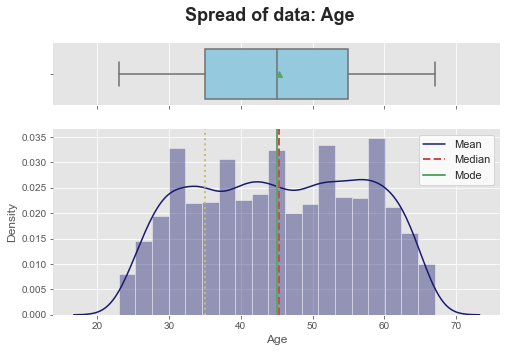

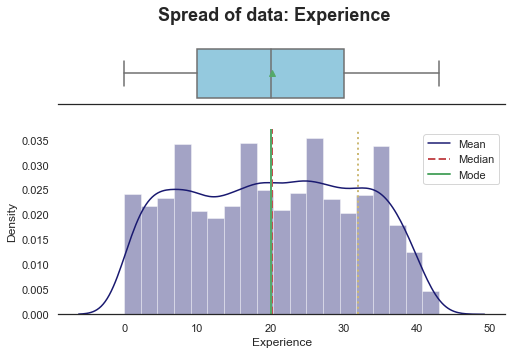

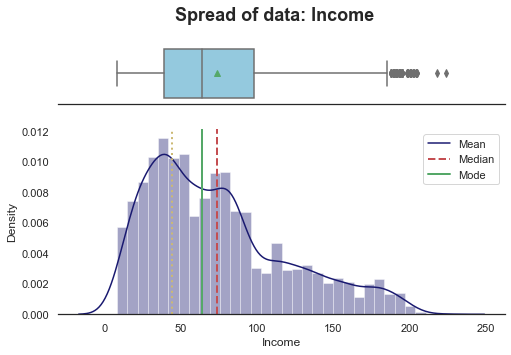

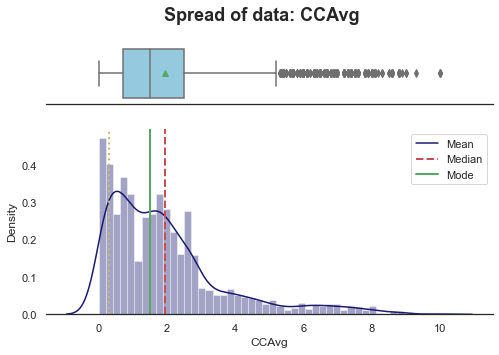

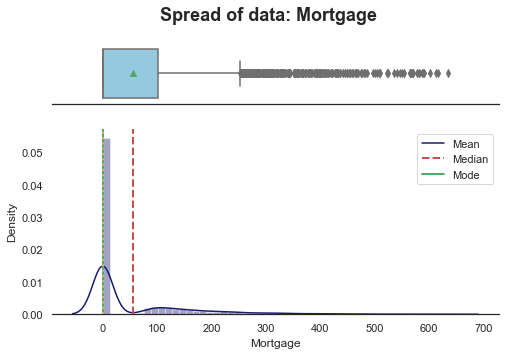

In [30]:
numeric_col = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
for col in numeric_col:
    dist_box(df_loan[col])

### Observations:

1. Both Age and Experience have similar distributions.
2. Income is right skewed with a few outliers on the higher side (which can be clipped).
3. Average monthly credit card spendings is right skewed and has a lot of outliers on the higher side.
4. Mortgage is mostly zero; but it is right skewed and has a lot of outliers on the higher side.

### Age

In [31]:
# Age can be a very important factor in the borrowing of loans. Hence, we are converting ages to bins 
# to find any underlying patterns.

df_loan['AgeBin'] = pd.cut(df_loan['Age'], bins = [0, 30, 40, 50, 60, 100], 
                          labels = ['18-30', '31-40', '41-50', '51-60', '61-100'])

### Income

In [32]:
# To understand customer segments, we are deriving new columns which will help us identify 
# if customer belongs to Upper, Middle or Lower income groups

df_loan['IncomeGroup'] = pd.cut(df_loan['Income'], bins = [0, 50, 140, 224], 
                               labels = ['Low', 'Middle', 'High'])

### Spending

In [33]:
# To understand customer spending, we are deriving new columns which will help us identify 
# if customer belongs to Upper, Middle or Lower spending groups

df_loan['SpendingGroup'] = pd.cut(df_loan['CCAvg'], bins = [0.0, 0.7, 2.5, 10.0], 
                               labels = ['Low', 'Middle', 'High'], include_lowest = True)

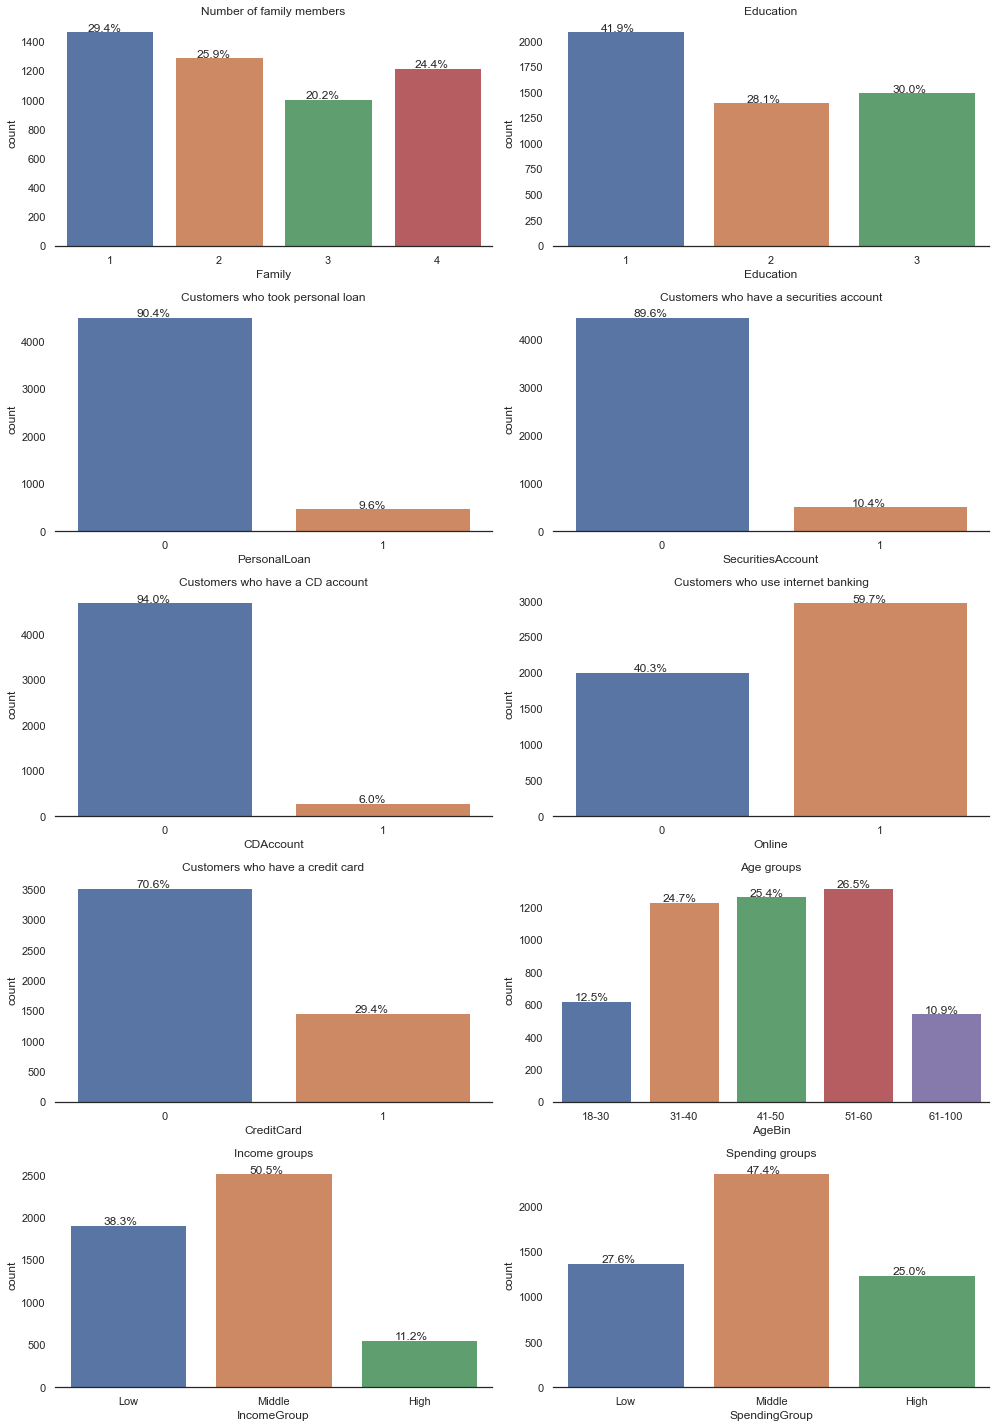

In [34]:
categorical_col = ['Family', 'Education', 'PersonalLoan', 'SecuritiesAccount', 'CDAccount', 'Online', 
                  'CreditCard', 'AgeBin', 'IncomeGroup', 'SpendingGroup']
title = ['Number of family members', 'Education', 'Customers who took personal loan', 
        'Customers who have a securities account', 'Customers who have a CD account', 'Customers who use internet banking', 
        'Customers who have a credit card', 'Age groups', 'Income groups', 'Spending groups']

plt.figure(figsize = (14, 20))
sns.set_theme(style = 'white')

for i, variable in enumerate(categorical_col):
    plt.subplot(5, 2, i + 1)
    order = df_loan[variable].value_counts(ascending = False).index
    sns.color_palette('Set2')
    ax = sns.countplot(x = df_loan[variable], data = df_loan)
    sns.despine(top = True, left = True, right = True)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height() / len(df_loan[variable]) * 100)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y), ha = 'center')
    plt.tight_layout()
    plt.title(title[i])

### Observations:

1. ~30% of customers are single.
2. ~42% of customers are Undergraduates.
3. ~10% of customers have borrowed a loan from the bank.
4. ~10% of customers have a securities account with the bank.
5. 6% of customers have a CD account with the bank.
6. ~60% of the customers use the bank's internet banking services.
7. ~29% of the customers have a credit card.
8. ~75% of the customers belong to the age group 31 to 60.
9. ~50% of the customers belong to the Middle income group.
10. ~47% of the customers have medium average spendings (through credit cards).

In [35]:
df_loan.groupby(['County', 'PersonalLoan'])['PersonalLoan'].agg({'size'}).unstack()

size     
PersonalLoan              0    1
County                          
9307                      1    0
96651                     6    0
Alameda County          456   44
Butte County             17    2
Contra Costa County      73   12
El Dorado County         16    1
Fresno County            24    2
Humboldt County          30    2
Imperial County           3    0
Kern County              47    7
Lake County               4    0
Los Angeles County      984  111
Marin County             48    6
Mendocino County          7    1
Merced County             4    0
Monterey County         113   15
Napa County               3    0
Orange County           333   33
Placer County            22    2
Riverside County         50    6
Sacramento County       169   15
San Benito County        14    0
San Bernardino County    98    3
San Diego County        509   59
San Francisco County    238   19
San Joaquin County       12    1
San Luis Obispo County   28    5
San Mateo County        192   12
Santa Barbara County    143   11
Santa Clara County      492   71
Santa Cruz County        60    8
Shasta County            15    3
Siskiyou County           7    0
Solano County            30    3
Sonoma County            22    6
Stanislaus County        14    1
Trinity County            4    0
Tuolumne County           7    0
Ventura County          103   11
Yolo County             122    8

<AxesSubplot:ylabel='County'>

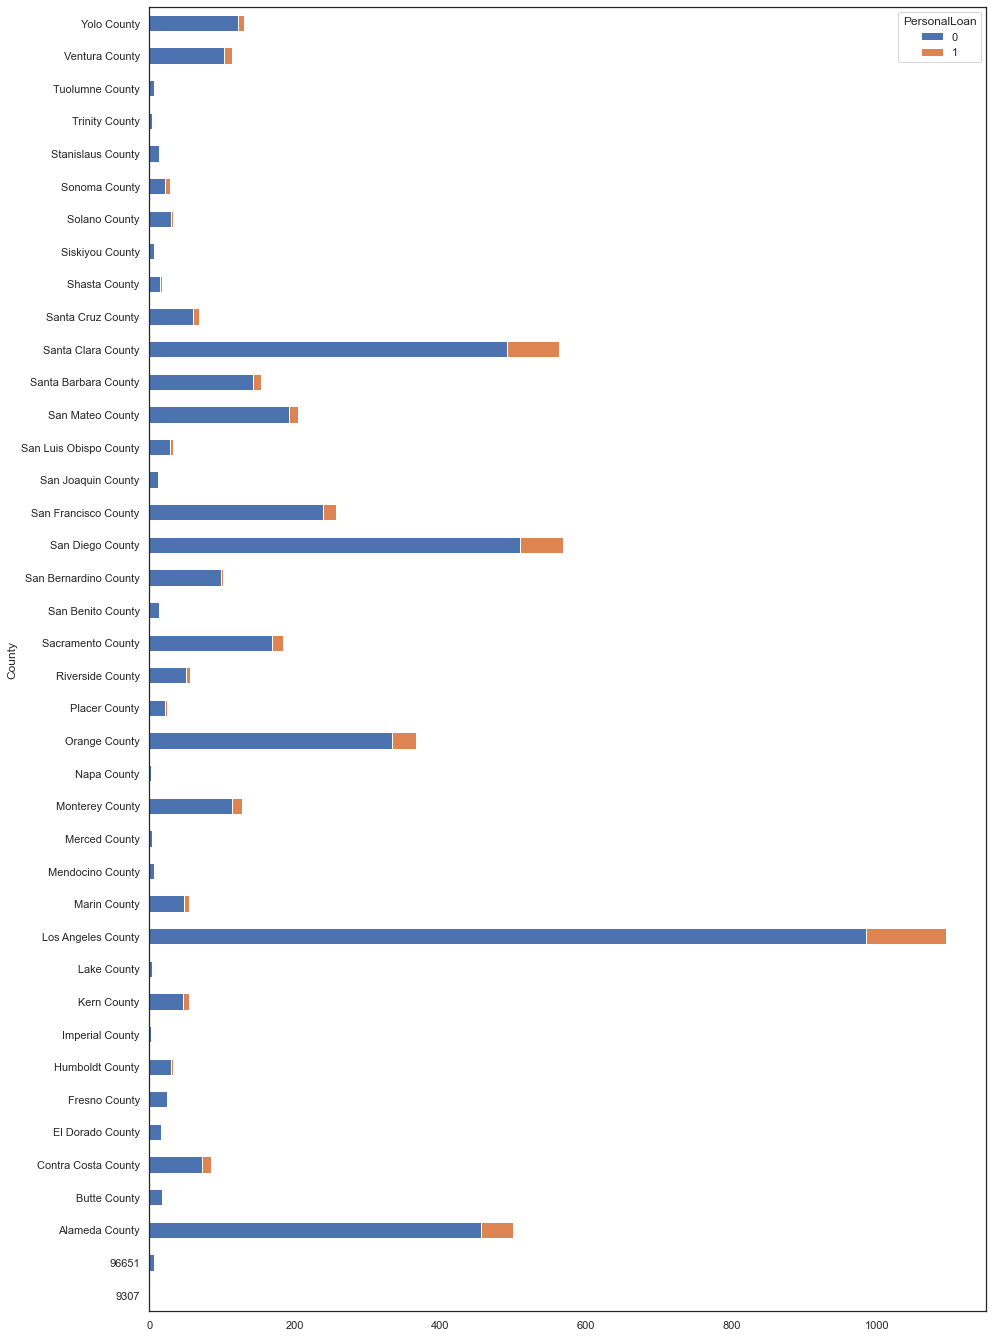

In [36]:
pd.crosstab(index = df_loan['County'], columns = df_loan['PersonalLoan'].sort_values(ascending = False)).plot(kind = 'barh', 
                                                                                                             stacked = True, 
                                                                                                             figsize = (15, 24))

In [37]:
# Converting the counties to regions to better understand the geographical distribution of asset customers
# Converting the counties to regions based on https://www.calbhbc.org/region-map-and-listing.html

counties = {
'Los Angeles County':'Los Angeles Region',
'San Diego County':'Southern',
'Santa Clara County':'Bay Area',
'Alameda County':'Bay Area',
'Orange County':'Southern',
'San Francisco County':'Bay Area',
'San Mateo County':'Bay Area',
'Sacramento County':'Central',
'Santa Barbara County':'Southern',
'Yolo County':'Central',
'Monterey County':'Bay Area',            
'Ventura County':'Southern',             
'San Bernardino County':'Southern',       
'Contra Costa County':'Bay Area',        
'Santa Cruz County':'Bay Area',           
'Riverside County':'Southern',            
'Kern County':'Southern',                 
'Marin County':'Bay Area',                
'San Luis Obispo County':'Southern',     
'Solano County':'Bay Area',              
'Humboldt County':'Superior',            
'Sonoma County':'Bay Area',                
'Fresno County':'Central',               
'Placer County':'Central',                
'Butte County':'Superior',               
'Shasta County':'Superior',                
'El Dorado County':'Central',             
'Stanislaus County':'Central',            
'San Benito County':'Bay Area',          
'San Joaquin County':'Central',           
'Mendocino County':'Superior',             
'Tuolumne County':'Central',                
'Siskiyou County':'Superior',              
'Trinity County':'Superior',                
'Merced County':'Central',                  
'Lake County':'Superior',                 
'Napa County':'Bay Area',                   
'Imperial County':'Southern',
93077:'Southern',
96651:'Bay Area'
}

In [38]:
df_loan["Region"] = df_loan['County'].map(counties)
df_loan['Region'].unique()

array(['Los Angeles Region', 'Bay Area', 'Southern', 'Superior',
       'Central', nan], dtype=object)

In [39]:
df_loan.dropna(inplace = True)

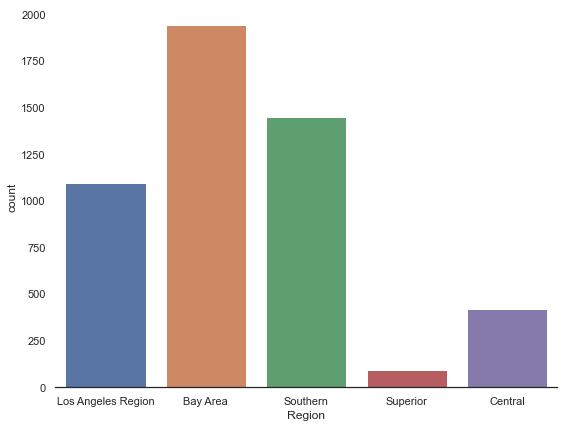

In [40]:
plt.figure(figsize = (9, 7))
sns.countplot(x = df_loan['Region'], data = df_loan)
sns.despine(top = True, left = True, right = True)

### Bivariate and Multivariate Analysis

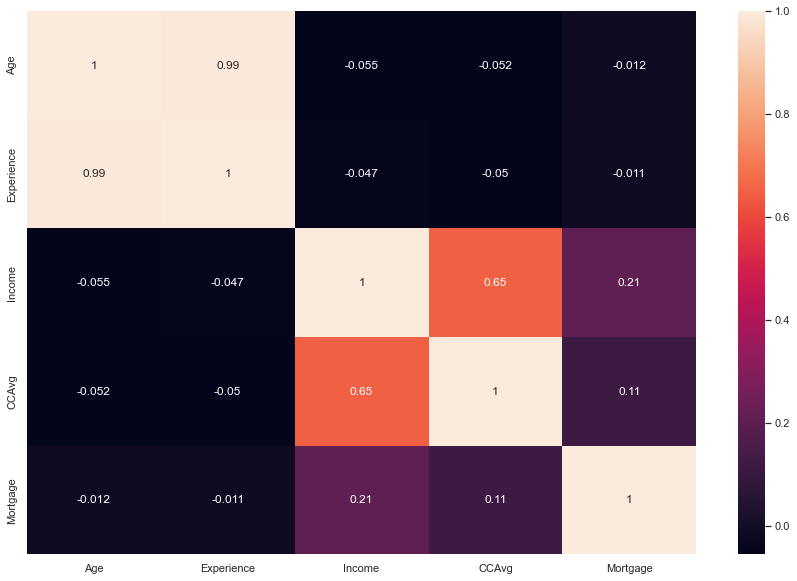

In [41]:
sns.color_palette('Set2')
plt.figure(figsize = (15, 10))
sns.heatmap(df_loan.corr(), annot = True)
plt.show()

#### Inference:

1. As expected, Age and Experience are highly correlated and one of them can be dropped. In case of Experience, since we have observations equating to zero, we will drop Experience.
2. Income and Average spending on credit cards are positively correlated.
3. Mortgage has very little correlation with Income.

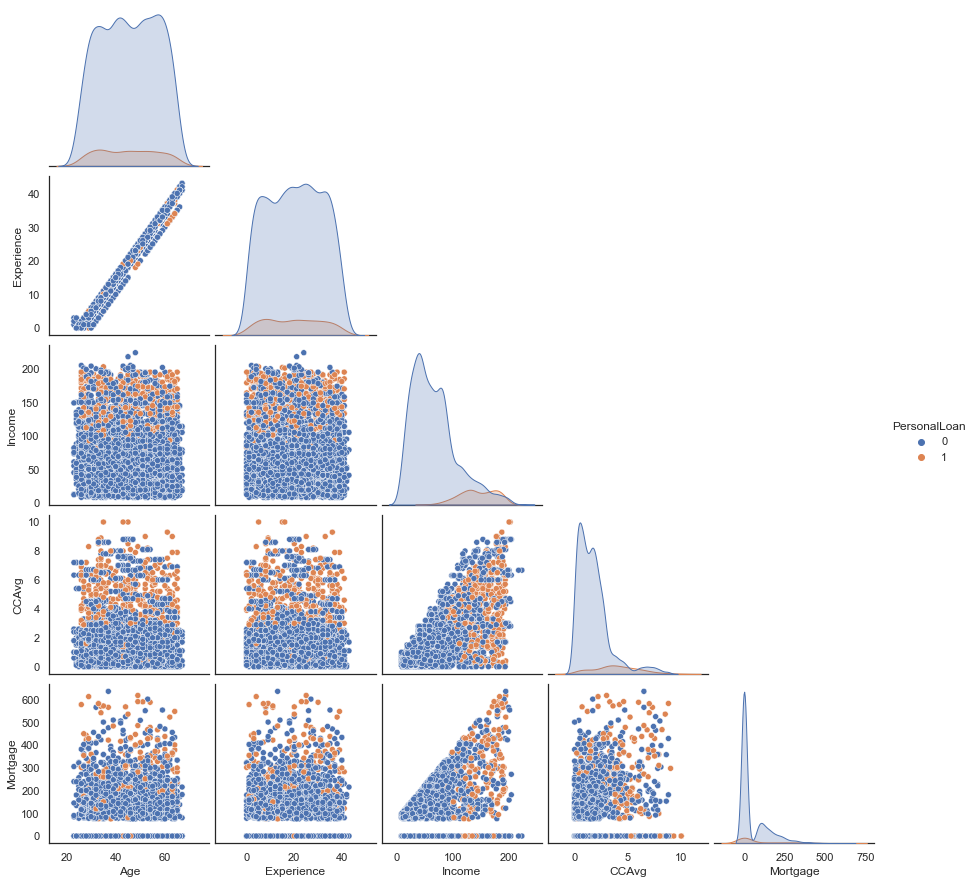

In [42]:
sns.color_palette("Set2")
sns.pairplot(df_loan, hue = 'PersonalLoan', corner = True)
plt.show()

### Observations:

1. The number of customers who have not borrowed any loans is way higher than the number of customers who have borrowed a loan.
2. Age and Experience are highly correlated (as expected).
3. Age and Income --> Customers with high incomes (from all age categories; above 100k per annum) have borrowed loans.
4. Age and CCAvg --> The customers who have a high monthly average credit card spending (roughly greater than 4k a month), have borrowed loans.
5. Income and CCAvg --> Customers having high incomes have a higher monthly average credit card spending.
6. Income and Mortgage --> Customers having high incomes have a high mortgage on their house and have borrowed personal loans as well.

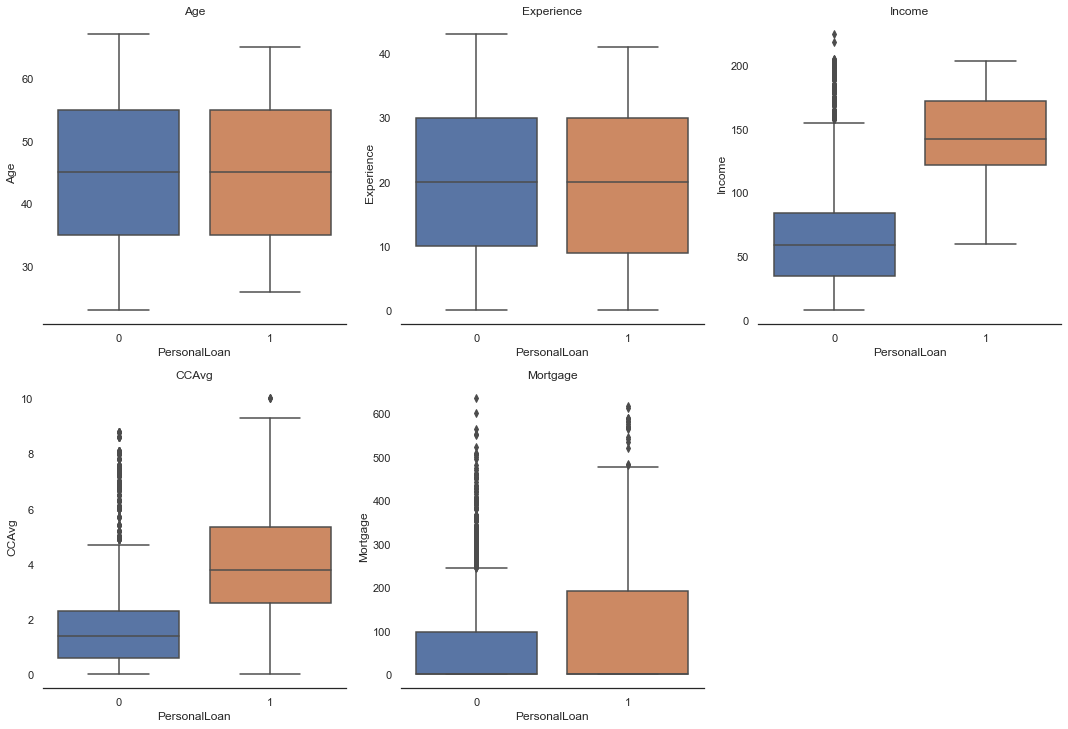

In [43]:
numeric_col = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
plt.figure(figsize = (15, 25))

sns.color_palette("Set2", 8)
for i, variable in enumerate(numeric_col):
    plt.subplot(5, 3, i + 1)
    sns.boxplot(x = 'PersonalLoan', y = df_loan[variable], data = df_loan)
    sns.despine(top = True, left = True, right = True)
    plt.tight_layout()
    plt.title(variable)

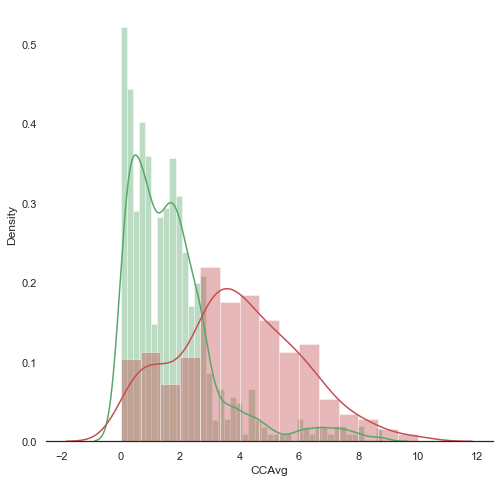

In [44]:
plt.figure(figsize = (8, 8))
sns.distplot(df_loan[df_loan['PersonalLoan'] == 0]['CCAvg'], color = 'g')
sns.distplot(df_loan[df_loan['PersonalLoan'] == 1]['CCAvg'], color = 'r')
sns.despine(top = True, left = True, right = True)

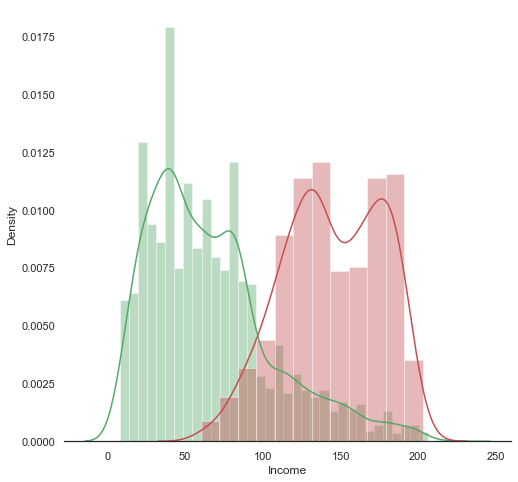

In [45]:
# Customers having high incomes (more than 100k per annum) have borrowed loans
plt.figure(figsize = (8, 8))
sns.distplot(df_loan[df_loan['PersonalLoan'] == 0]['Income'], color = 'g')
sns.distplot(df_loan[df_loan['PersonalLoan'] == 1]['Income'], color = 'r')
sns.despine(top = True, left = True, right = True)

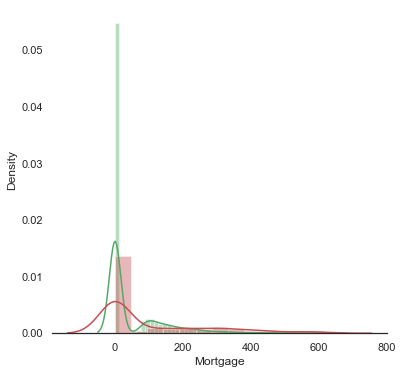

In [46]:
plt.figure(figsize = (6, 6))
sns.distplot(df_loan[df_loan['PersonalLoan'] == 0]['Mortgage'], color = 'g')
sns.distplot(df_loan[df_loan['PersonalLoan'] == 1]['Mortgage'], color = 'r')
sns.despine(top = True, left = True, right = True)

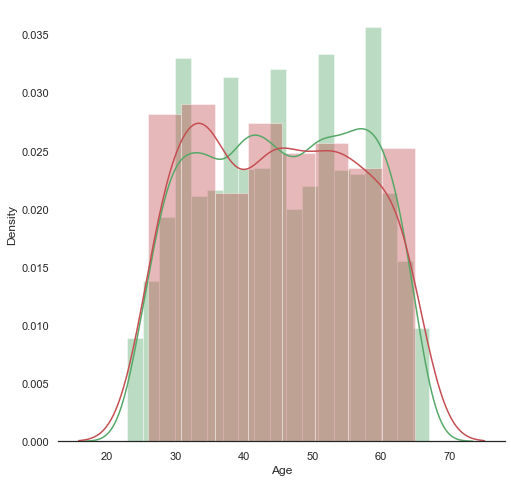

In [47]:
# The distribution of loan borrowers vs non-borrowers with respect to the age is fairly evenly distributed
plt.figure(figsize = (8, 8))
sns.distplot(df_loan[df_loan['PersonalLoan'] == 0]['Age'], color = 'g')
sns.distplot(df_loan[df_loan['PersonalLoan'] == 1]['Age'], color = 'r')
sns.despine(top = True, left = True, right = True)

<Figure size 576x576 with 0 Axes>

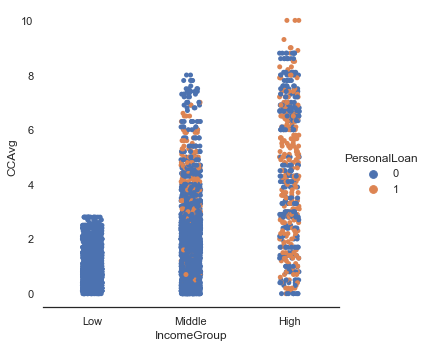

In [48]:
# Income and CCAvg are directly proportional or highly correlated (as expected)
plt.figure(figsize = (8, 8))
sns.catplot(x = 'IncomeGroup', y = 'CCAvg', hue = 'PersonalLoan', data = df_loan)
sns.despine(top = True, left = True, right = True)

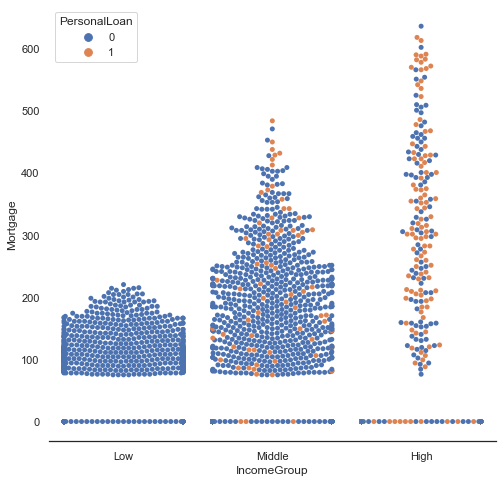

In [49]:
# Income and Mortgage amount are also positively correlated (as expected)
plt.figure(figsize = (8, 8))
sns.swarmplot(x = 'IncomeGroup', y = 'Mortgage', hue = 'PersonalLoan', data = df_loan)
sns.despine(top = True, left = True, right = True)

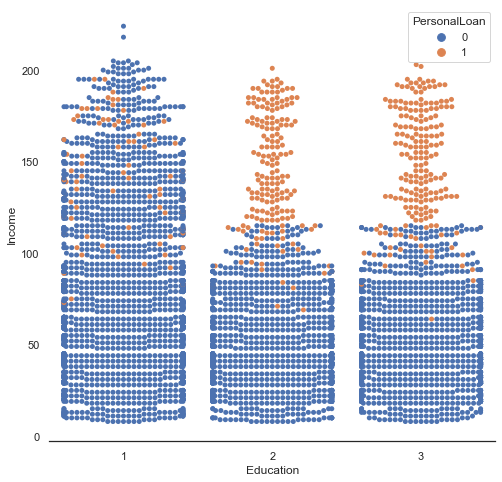

In [50]:
# Graduates and Advanced professionals (belonging to high Income groups) have borrowed significantly more loans than Undergraduate customers
plt.figure(figsize = (8, 8))
sns.swarmplot(x = 'Education', y = 'Income', hue = 'PersonalLoan', data = df_loan)
sns.despine(top = True, left = True, right = True)

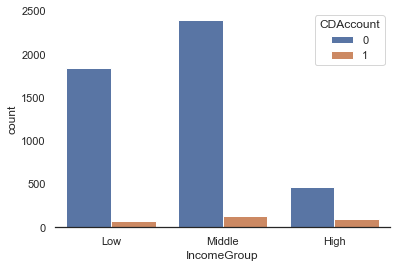

In [51]:
sns.countplot(x = 'IncomeGroup', hue = 'CDAccount', data = df_loan)
sns.despine(top = True, left = True, right = True)

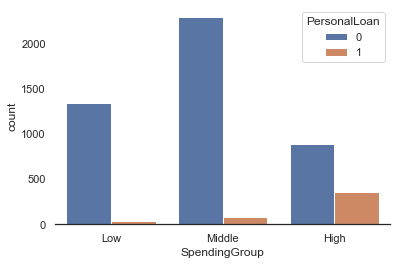

In [52]:
sns.countplot(x = 'SpendingGroup', hue = 'PersonalLoan', data = df_loan)
sns.despine(top = True, left = True, right = True)

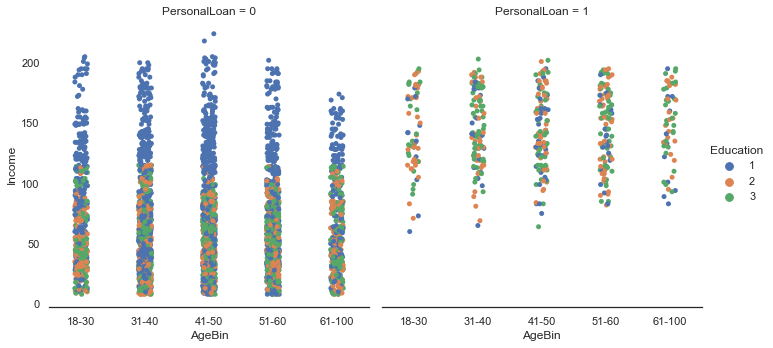

In [53]:
# Observations:
# 1. Customers who have not borrowed any loans and are undergraduates, are earning more than  the ones who have completed their graduation and post-graduation
# 2. Majority of the customers who have borrowed a loan, have completed their graduation and/or post-graduation.
sns.catplot(x = 'AgeBin', y = 'Income', hue = 'Education', col = 'PersonalLoan', data = df_loan)
sns.despine(top = True, left = True, right = True)

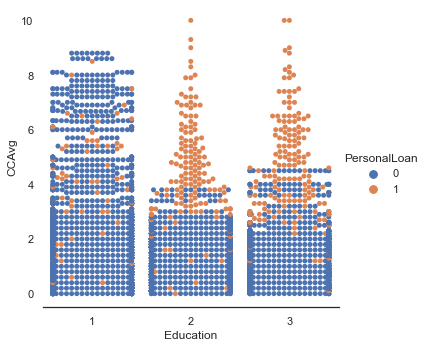

In [54]:
sns.catplot(x = 'Education', y = 'CCAvg', hue = 'PersonalLoan', data = df_loan, kind = 'swarm')
sns.despine(top = True, left = True, right = True)

In [55]:
def stacked_plot(x):
    sns.color_palette("Set2")
    tab1 = pd.crosstab(x, df_loan['PersonalLoan'], margins = True)
    print(tab1)
    print('-'*120)
    tab = pd.crosstab(x, df_loan['PersonalLoan'], normalize = 'index')
    tab.plot(kind = 'bar', stacked = True, figsize = (8, 4))
    plt.xticks(rotation = 360)
    sns.despine(top = True, left = True, right = True)
    plt.show()

PersonalLoan     0    1   All
Family                       
1             1365  107  1472
2             1190  106  1296
3              877  133  1010
4             1087  134  1221
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


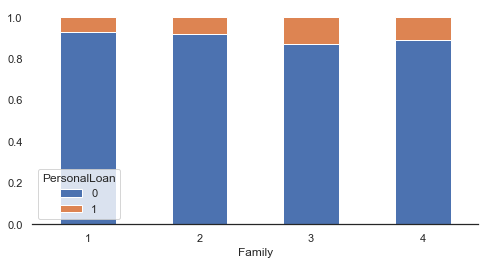

PersonalLoan     0    1   All
Education                    
1             2003   93  2096
2             1221  182  1403
3             1295  205  1500
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


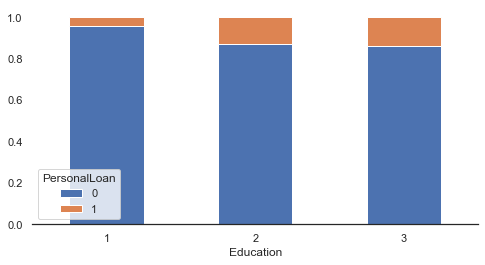

PersonalLoan          0    1   All
SecuritiesAccount                 
0                  4057  420  4477
1                   462   60   522
All                4519  480  4999
------------------------------------------------------------------------------------------------------------------------


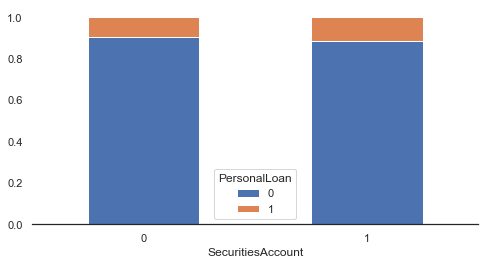

PersonalLoan     0    1   All
CDAccount                    
0             4357  340  4697
1              162  140   302
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


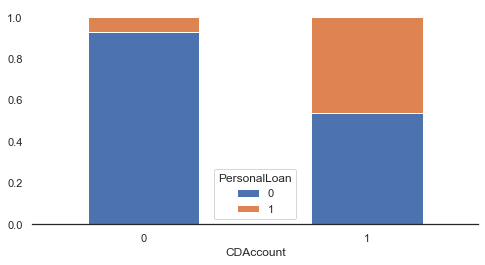

PersonalLoan     0    1   All
Online                       
0             1827  189  2016
1             2692  291  2983
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


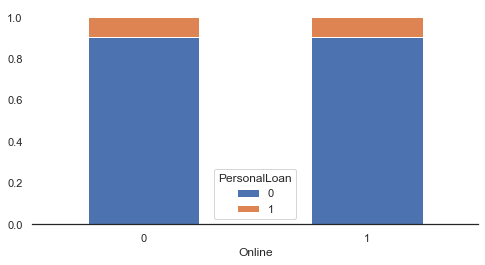

PersonalLoan           0    1   All
Region                             
Bay Area            1747  196  1943
Central              390   30   420
Los Angeles Region   984  111  1095
Southern            1314  135  1449
Superior              84    8    92
All                 4519  480  4999
------------------------------------------------------------------------------------------------------------------------


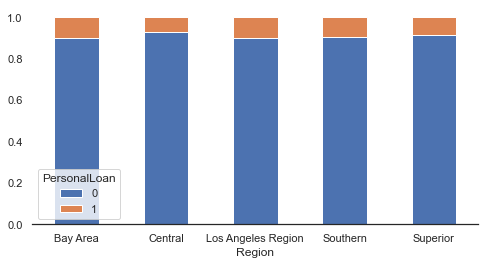

PersonalLoan     0    1   All
CreditCard                   
0             3193  337  3530
1             1326  143  1469
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


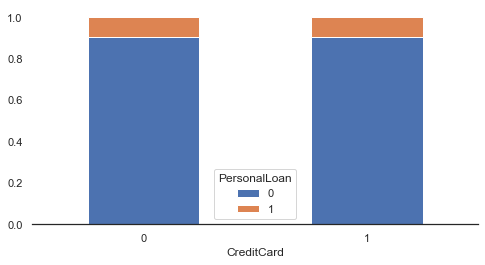

PersonalLoan     0    1   All
AgeBin                       
18-30          558   66   624
31-40         1118  118  1236
41-50         1148  122  1270
51-60         1207  115  1322
61-100         488   59   547
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


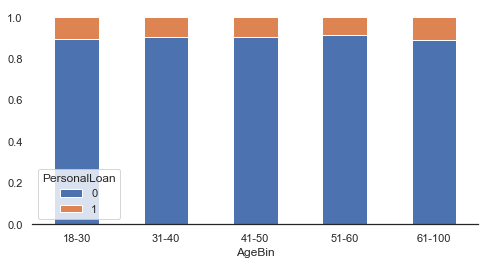

PersonalLoan     0    1   All
IncomeGroup                  
Low           1913    0  1913
Middle        2301  223  2524
High           305  257   562
All           4519  480  4999
------------------------------------------------------------------------------------------------------------------------


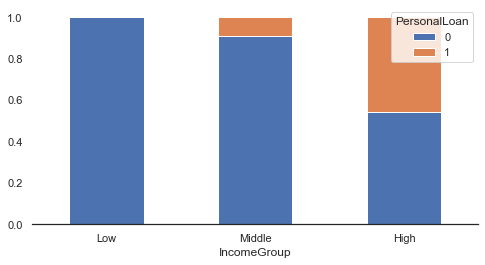

PersonalLoan      0    1   All
SpendingGroup                 
Low            1341   39  1380
Middle         2292   79  2371
High            886  362  1248
All            4519  480  4999
------------------------------------------------------------------------------------------------------------------------


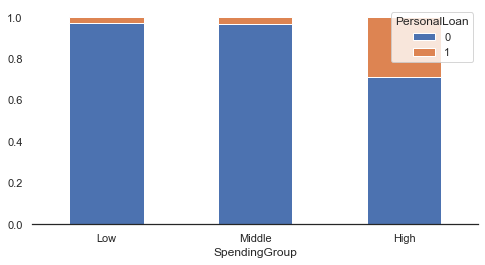

In [56]:
categorical_col2 = ['Family', 'Education', 'SecuritiesAccount', 'CDAccount', 'Online', 'Region', 
                  'CreditCard', 'AgeBin', 'IncomeGroup', 'SpendingGroup']
for i, variable in enumerate(categorical_col2):
    stacked_plot(df_loan[variable])

### Observations:

1. Number of customers with family size of 3, who had borrowed a loan from the bank is greater than the other family sizes.
2. 60 customers who had borrowed a loan from the bank, also had a securities account with the bank.
3. Customers using internet banking facilities has no impact on borrowing a Personal Loan.
4. Majority of the customers who have borrowed a loan are from the Bay Area and Los Angeles Region.
5. Majority of the customers who did have a personal loan with the bank did not use credit cards from any other banks.
6. Loan borrowers majorly belong to the 30 to 60 year age-group.
7. Customers with high income and hence, high monthly average spending on credit cards have borrowed more loans.

### Check distribution in target column

([<matplotlib.patches.Wedge at 0x22c5872e880>,
 [Text(-1.0503312798154913, 0.3268091226406516, ''),
  Text(1.0503312721659712, -0.3268091472254298, '')],
 [Text(-0.5729079708084497, 0.1782595214403554, '90.4%'),
  Text(0.5729079666359843, -0.1782595348502344, '9.6%')])

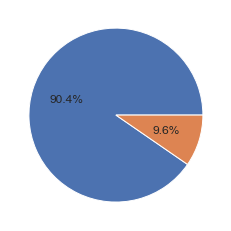

In [57]:
# The target variable 'PersonalLoan' is highly imbalanced where only 9.6% of the customers have borrowed a loan from the bank.
# This can be handled using weight or SMOTE. But for now, we will carry on without SMOTE.

plt.pie(x = df_loan['PersonalLoan'].value_counts(), autopct = '%1.1f%%')

In [58]:
# Saving dataset before treating it for outliers for Logistic Regression

df_decision = df_loan.copy(deep = True) 

### Inferences based on EDA:

#### Data Description:
1. Dependent variable is PersonalLoan which is of categorical data type.
2. Age, Experience, Income, Mortgage, CCAvg are of numerical data while other independent variables are categorical in nature.
3. There were no missing values in the dataset.

#### Data Cleaning:
1. We observed that some observations were negative for the Experience column; but since there is a strong correlation between Age and Experience, we have dropped the Experience column.
2. There are 450 unique zipcodes which we have mapped to respective counties. These counties were further mapped to regions to reduce the dimension of the data and we now have only 5 distinct regions in the data.
3. We have also created AgeBin, IncomeGroup and SpendingGroup to understand the underlying pattern between these and the dependent variable.

#### Customer segmentation for borrowing loan based on EDA:
1. Customers belonging to high income groups have high mortgages and high monthly average credit card spending. They also have a Certificate of Deposit with the bank. They are our high profile clients.
2. Few customers in the medium income groups dont have high mortgages and have less monthly average credit card spending. They are our average profile clients.
3. Customers in the lower income groups have less mortgages (there are a few outliers) and less monthly average credit card spending. They are our low profile clients.

#### Actions for data pre-processing.
1. Many variables have outliers that need to be treated.
2. We can drop Experience, County, ZIPCode, and AgeBin, IncomeGroup and SpendingGroup

### Outliers Detection

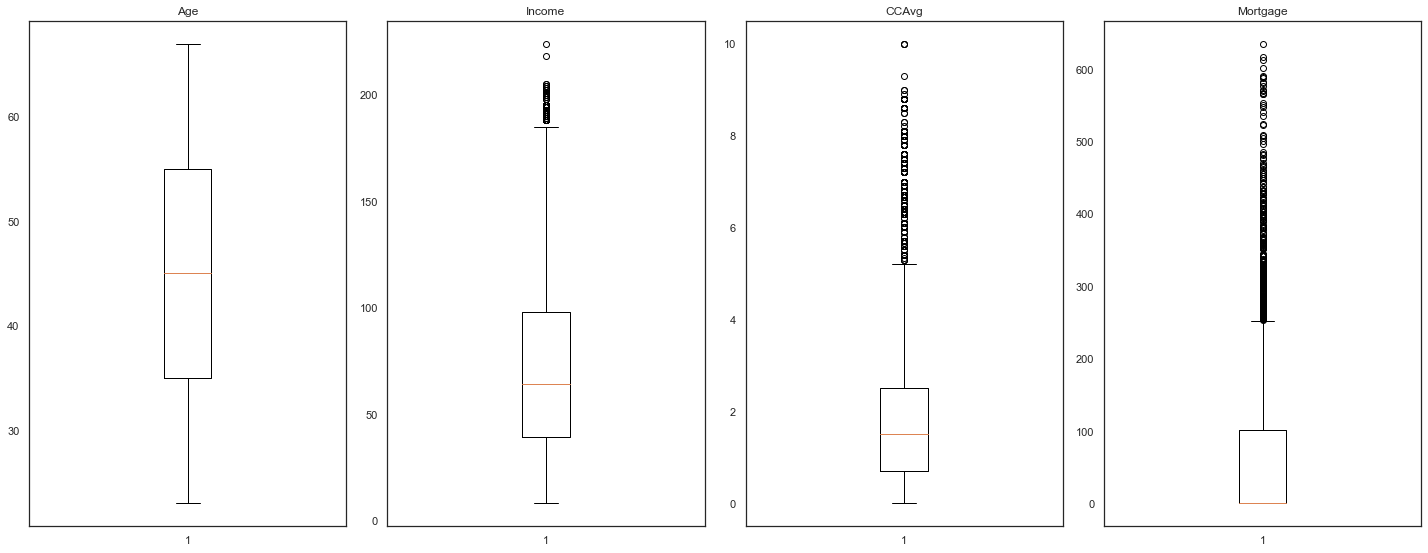

In [59]:
numeric_col2 = ['Age', 'Income', 'CCAvg', 'Mortgage']
plt.figure(figsize = (20, 30))
for i, variable in enumerate(numeric_col2):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df_loan[variable], whis = 1.5)
    plt.tight_layout()
    plt.title(variable)

In [60]:
# Check for outliers in the Income column

# df_loan.sort_values(by = ['Income'], ascending = False).head(5)
df_loan.loc[df_loan['Income'] > 187]    # 187 = Max + 1.5 * IQR

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,County,AgeBin,IncomeGroup,SpendingGroup,Region
18,46,21,193,91604,2,8.100,3,0,1,0,0,0,0,Los Angeles County,41-50,High,High,Los Angeles Region
47,37,12,194,91380,4,0.200,3,211,1,1,1,1,1,Los Angeles County,31-40,High,Low,Los Angeles Region
53,50,26,190,90245,3,2.100,3,240,1,0,0,1,0,Los Angeles County,41-50,High,Middle,Los Angeles Region
59,31,5,188,91320,2,4.500,1,455,0,0,0,0,0,Ventura County,31-40,High,High,Southern
303,49,25,195,95605,4,3.000,1,617,1,0,0,0,0,Yolo County,41-50,High,High,Central
329,28,4,191,90064,1,6.330,1,0,0,0,0,1,0,Los Angeles County,18-30,High,High,Los Angeles Region
459,35,10,200,91107,2,3.000,1,458,0,0,0,0,0,Los Angeles County,31-40,High,High,Los Angeles Region
526,26,2,205,93106,1,6.330,1,271,0,0,0,0,1,Santa Barbara County,18-30,High,High,Southern
677,46,21,204,92780,2,2.800,1,0,0,0,0,1,0,Orange County,41-50,High,High,Southern
740,52,27,195,90266,1,8.100,1,0,0,0,0,0,0,Los Angeles County,51-60,High,High,Los Angeles Region


In [61]:
# Check for outliers in the Mortgage column

df_loan.sort_values(by = ['Mortgage'], ascending = False).head(5)
df_loan.loc[df_loan['Mortgage'] > 253]    # 253 = Max + 1.5 * IQR

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,County,AgeBin,IncomeGroup,SpendingGroup,Region
22,29,5,62,90277,1,1.200,1,260,0,0,0,1,0,Los Angeles County,18-30,Middle,Middle,Los Angeles Region
39,38,13,80,94115,4,0.700,3,285,0,0,0,1,0,San Francisco County,31-40,Middle,Low,Bay Area
42,32,7,132,90019,4,1.100,2,412,1,0,0,1,0,Los Angeles County,31-40,Middle,Middle,Los Angeles Region
59,31,5,188,91320,2,4.500,1,455,0,0,0,0,0,Ventura County,31-40,High,High,Southern
66,62,36,105,95670,2,2.800,1,336,0,0,0,0,0,Sacramento County,61-100,Middle,High,Central
112,40,15,82,91775,3,1.000,1,309,0,0,0,0,0,Los Angeles County,31-40,Middle,Middle,Los Angeles Region
119,32,7,112,94304,1,4.600,1,366,0,0,0,0,0,Santa Clara County,31-40,Middle,High,Bay Area
130,28,4,81,94801,3,1.500,1,276,0,0,0,1,0,Contra Costa County,18-30,Middle,Middle,Bay Area
187,46,21,159,94305,3,1.900,3,315,1,0,0,1,0,Santa Clara County,41-50,High,Middle,Bay Area
209,64,39,172,94707,4,3.100,1,282,1,0,1,1,1,Alameda County,61-100,High,High,Bay Area


In [62]:
# Check for outliers in the CCAvg column

df_loan.sort_values(by = ['CCAvg'], ascending = False).head(5)
df_loan.loc[df_loan['CCAvg'] > 5.2]    # 5.2 = Max + 1.5 * IQR

,Age,Experience,Income,ZIPCode,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,County,AgeBin,IncomeGroup,SpendingGroup,Region
9,34,9,180,93023,1,8.900,3,0,1,0,0,0,0,Ventura County,31-40,High,High,Southern
18,46,21,193,91604,2,8.100,3,0,1,0,0,0,0,Los Angeles County,41-50,High,High,Los Angeles Region
44,46,20,104,94065,1,5.700,1,0,0,0,0,1,1,San Mateo County,41-50,Middle,High,Bay Area
55,41,17,139,94022,2,8.000,1,0,0,0,0,1,0,Santa Clara County,41-50,Middle,High,Bay Area
61,47,21,125,93407,1,5.700,1,112,0,1,0,0,0,San Luis Obispo County,41-50,Middle,High,Southern
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4908,40,16,138,92121,2,6.100,1,0,0,0,0,1,0,San Diego County,31-40,Middle,High,Southern
4911,46,22,153,94539,2,7.500,1,0,0,0,0,0,0,Alameda County,41-50,High,High,Bay Area
4937,33,8,162,94960,1,8.600,1,0,0,0,1,1,1,Marin County,31-40,High,High,Bay Area
4980,29,5,135,95762,3,5.300,1,0,1,0,1,1,1,El Dorado County,18-30,Middle,High,Central


### Inference:

1. There are some really extreme values for Income (224k USD) compared to the same age group and experience.
2. Values for credit card spending and mortgages are also extreme; after identifying outliers we can decide whether to remove them or treat them.

In [63]:
# Dropping columns

df_loan.drop(columns = ['AgeBin', 'IncomeGroup', 'SpendingGroup', 'ZIPCode', 'County', 'Experience'], inplace = True)

In [64]:
# We have 6 categorical independent variables but 4 of them are binary (SecuritiesAccount, CDAccount, Online and CreditCard);
# so we'll obtain the same result with them even after creating dummies.
# So we will only make dummies for Region and Education

X = df_loan.drop(['PersonalLoan'], axis = 1)
Y = df_loan['PersonalLoan']

oneHotCols = ['Region', 'Education']
X = pd.get_dummies(X, columns = oneHotCols, drop_first = True)

In [65]:
# Splitting the data in train and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = Y)

In [66]:
from sklearn.preprocessing import StandardScaler

# Creating a StandardScalar instance
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)

X_train_scaled_df.index = np.arange(len(X_train_scaled_df))
X_test_scaled_df.index = np.arange(len(X_test_scaled_df))

Y_train.index = np.arange(len(Y_train))
Y_test.index = np.arange(len(Y_test))

### Model Building: Logistic Regression

#### Model evaluation criteria:

--> Model can make wrong predictions as:
1. Predicting a person will buy a loan but he actually does not (Loss of Resource).
2. Predicting a person will not buy a loan but he actually does (Loss of Opportunity).

--> Which case is more important to us?
The whole purpose of the campaign is to bring in more customers. The 2nd case is more important to us; a potential customer is missed by the sales and marketing team (Loss of Opportunity). We wish to minimise this loss.

--> How to reduce the losses; i.e. the False Negatives?
1. In this case, recall is the right metric to check the performance of the model. Bank wants recall to be maximized; greater the recall, lesser the chances of False Negatives.
2. Accuracy wont be the right metric to check the model's performance because the data is imbalanced.

In [67]:
def make_confusion_matrix(Y_actual, Y_predict, title):
    fig, ax = plt.subplots(1, 1)
    cm = confusion_matrix(Y_actual, Y_predict, labels = [0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No', 'Yes'])
    disp.plot(cmap = 'Greens', colorbar = True, ax = ax)
    ax.set_title(title)
    plt.tick_params(axis = u'both', which = u'both', length = 0)
    plt.grid(b = None, axis = 'both', which = 'both', visible = False)
    plt.show()

In [68]:
def get_metrics_score(model, X_train_df, X_test_df, Y_train_pass, Y_test_pass, statsklearn, 
                     threshold = 0.5, flag = True, roc = False):
    score_list = []
    if statsklearn == 0:
        pred_train = model.predict(X_train_df)
        pred_test = model.predict(X_test_df)
        
    else:
        pred_train = (model.predict(X_train_df) > threshold)
        pred_test = (model.predict(X_test_df) > threshold)
        
    pred_train = np.round(pred_train)
    pred_test = np.round(pred_test)
    
    train_acc = accuracy_score(Y_train_pass, pred_train)
    test_acc = accuracy_score(Y_test_pass, pred_test)
    
    train_recall = recall_score(Y_train_pass, pred_train)
    test_recall = recall_score(Y_test_pass, pred_test)
    
    train_precision = precision_score(Y_train_pass, pred_train)
    test_precision = precision_score(Y_test_pass, pred_test)
    
    train_f1 = f1_score(Y_train_pass, pred_train)
    test_f1 = f1_score(Y_test_pass, pred_test)
    
    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_precision, test_precision, 
                     train_f1, test_f1))
    
    if flag == True:
        print("\x1b[0;30;47m \033[1mModel Performance\x1b[0m")
        
        print("\x1b[0;30;47m \033[1mAccuracy   : Train:\x1b[0m",
              round(accuracy_score(Y_train_pass, pred_train), 3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m ",
              round(accuracy_score(Y_test_pass, pred_test), 3))
        
        print("\x1b[0;30;47m \033[1mRecall     : Train:\x1b[0m"
              ,round(recall_score(Y_train_pass, pred_train), 3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m" ,
              round(recall_score(Y_test_pass, pred_test), 3))
        
        print("\x1b[0;30;47m \033[1mPrecision  : Train:\x1b[0m",
              round(precision_score(Y_train_pass, pred_train), 3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m ",
              round(precision_score(Y_test_pass, pred_test), 3))
        
        print("\x1b[0;30;47m \033[1mF1         : Train:\x1b[0m",
              round(f1_score(Y_train_pass, pred_train), 3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m",
              round(f1_score(Y_test_pass, pred_test), 3))
        
        make_confusion_matrix(Y_train_pass, pred_train, 'Confusion  Matrix for Train Data')
        
        make_confusion_matrix(Y_test_pass, pred_test, 'Confusion  Matrix for Test Data')
        
        if roc == True:
            
            print("\x1b[0;30;47m \033[1mROC-AUC Score  :Train:\x1b[0m: ",
              round(roc_auc_score(Y_train_pass, pred_train), 3),
              "\x1b[0;30;47m \033[1mTest:\x1b[0m: ",
              round(roc_auc_score(Y_test_pass, pred_test), 3))
            
        return score_list

In [69]:
# defining empty lists to add train and test results

acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

def add_score_model(score):
    # Add scores to the list so that we can compare all models' score together
    
    acc_train.append(score[0])
    acc_test.append(score[1])
    recall_train.append(score[2])
    recall_test.append(score[3])
    precision_train.append(score[4])
    precision_test.append(score[5])
    f1_train.append(score[6])
    f1_test.append(score[7])

### Logistic Regression with sklearn library

 Model Performance
 Accuracy   : Train: 0.658  Test:  0.65
 Recall     : Train: 0.979  Test: 0.986
 Precision  : Train: 0.217  Test:  0.214
 F1         : Train: 0.355  Test: 0.351


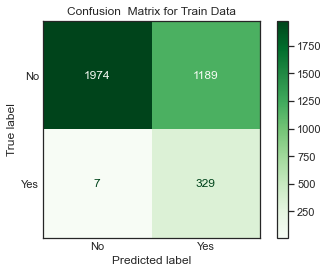

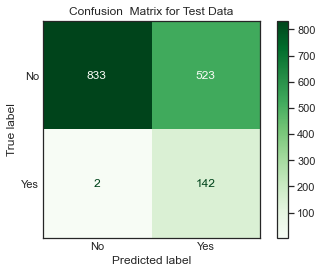

In [70]:
lr = LogisticRegression(solver = 'newton-cg', random_state = 1, fit_intercept = False, class_weight = {0:0.15, 1:0.85})
model = lr.fit(X_train_scaled_df, Y_train)

statmodel = 0    # 0 for sklearn and 1 for statmodel

scores_Sklearn = get_metrics_score(model, X_train_scaled_df, X_test_scaled_df, Y_train, Y_test, statmodel)

In [71]:
add_score_model(scores_Sklearn)

### Logistic Regression with Statmodel

Optimization terminated successfully.
         Current function value: 0.113898
         Iterations 9
 Model Performance
 Accuracy   : Train: 0.962  Test:  0.953
 Recall     : Train: 0.688  Test: 0.653
 Precision  : Train: 0.888  Test:  0.817
 F1         : Train: 0.775  Test: 0.726


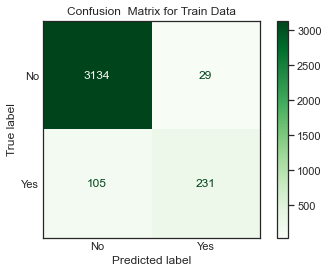

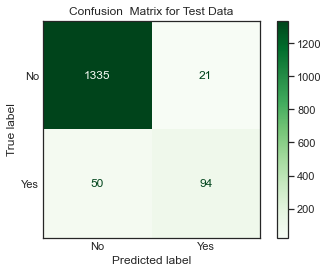

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           PersonalLoan   No. Observations:                 3499
Model:                          Logit   Df Residuals:                     3483
Method:                           MLE   Df Model:                           15
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                  0.6399
Time:                        13:18:05   Log-Likelihood:                -398.53
converged:                       True   LL-Null:                       -1106.6
Covariance Type:            nonrobust   LLR p-value:                5.492e-293
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.2604      0.236    -22.276      0.000      -5.723      -4.798
Age                           0.1547      0.096      1.618      0.106      -0.033       0.342
Income                        3.0106      0.177     17.055      0.000       2.665       3.357
Family                        0.7829      0.108      7.278      0.000       0.572       0.994
CCAvg                         0.2176      0.094      2.310      0.021       0.033       0.402
Mortgage                      0.0874      0.073      1.206      0.228      -0.055       0.230
SecuritiesAccount            -0.2303      0.112     -2.056      0.040      -0.450      -0.011
CDAccount                     0.8431      0.100      8.459      0.000       0.648       1.038
Online                       -0.3423      0.099     -3.457      0.001      -0.536      -0.148
CreditCard                   -0.3662      0.116     -3.153      0.002      -0.594      -0.139
Region_Central               -0.1968      0.111     -1.781      0.075      -0.413       0.020
Region_Los Angeles Region    -0.0451      0.102     -0.444      0.657      -0.244       0.154
Region_Southern              -0.0149      0.104     -0.143      0.886      -0.219       0.189
Region_Superior              -0.3143      0.216     -1.456      0.145      -0.737       0.109
Education_2                   1.8569      0.150     12.375      0.000       1.563       2.151
Education_3                   1.9912      0.152     13.101      0.000       1.693       2.289
=============================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [72]:
# Adding a constant to the training and test sets
X_train_stat = sm.add_constant(X_train_scaled_df)
X_test_stat = sm.add_constant(X_test_scaled_df)

statmodel = 1

logit = sm.Logit(Y_train, X_train_stat.astype(float))
lg = logit.fit(warn_convergence = False)

scores_statmodel = get_metrics_score(lg, X_train_stat, X_test_stat, Y_train, Y_test, statmodel)
lg.summary()

### Test Assumption

#### MultiCollinearity
- We will have to check and remove multicollinearity from the data to get reliable coefficients and p-values. 
- There are different ways of detecting multicollinearity. One such way is the Variation Inflation Factor.
- General Rule of Thumb: If VIF is 1, then there is no corelation among the variables. Whereas, if VIF exceeds 5, we say that it shows signs of high-multicollinearity.
- But, the purpose of the analysis should dictate which threshold to use.

In [73]:
# Changing datatype of columns to numeric for checking VIF
X_train_num = X_train_stat.astype(float).copy()

In [74]:
vif_series1 = pd.Series([variance_inflation_factor(X_train_num.values, i) for i  in range(X_train_num.shape[1])], 
                       index = X_train_num.columns, dtype = float)

print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                       1.000
Age                         1.010
Income                      1.908
Family                      1.050
CCAvg                       1.743
Mortgage                    1.064
SecuritiesAccount           1.155
CDAccount                   1.358
Online                      1.047
CreditCard                  1.115
Region_Central              1.118
Region_Los Angeles Region   1.221
Region_Southern             1.241
Region_Superior             1.028
Education_2                 1.287
Education_3                 1.259
dtype: float64



#### Observation:
- There is no correlation between predictor variables

In [75]:
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           PersonalLoan   No. Observations:                 3499
Model:                          Logit   Df Residuals:                     3483
Method:                           MLE   Df Model:                           15
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                  0.6399
Time:                        13:18:10   Log-Likelihood:                -398.53
converged:                       True   LL-Null:                       -1106.6
Covariance Type:            nonrobust   LLR p-value:                5.492e-293
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.2604      0.236    -22.276      0.000      -5.723      -4.798
Age                           0.1547      0.096      1.618      0.106      -0.033       0.342
Income                        3.0106      0.177     17.055      0.000       2.665       3.357
Family                        0.7829      0.108      7.278      0.000       0.572       0.994
CCAvg                         0.2176      0.094      2.310      0.021       0.033       0.402
Mortgage                      0.0874      0.073      1.206      0.228      -0.055       0.230
SecuritiesAccount            -0.2303      0.112     -2.056      0.040      -0.450      -0.011
CDAccount                     0.8431      0.100      8.459      0.000       0.648       1.038
Online                       -0.3423      0.099     -3.457      0.001      -0.536      -0.148
CreditCard                   -0.3662      0.116     -3.153      0.002      -0.594      -0.139
Region_Central               -0.1968      0.111     -1.781      0.075      -0.413       0.020
Region_Los Angeles Region    -0.0451      0.102     -0.444      0.657      -0.244       0.154
Region_Southern              -0.0149      0.104     -0.143      0.886      -0.219       0.189
Region_Superior              -0.3143      0.216     -1.456      0.145      -0.737       0.109
Education_2                   1.8569      0.150     12.375      0.000       1.563       2.151
Education_3                   1.9912      0.152     13.101      0.000       1.693       2.289
=============================================================================================

Possibly complete quasi-separation: A fraction 0.13 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [76]:
# In this case, all the 'Region' attributes have a high p-value which means it is not significant;
# therefore, we can drop the complete variable

X_train1 = X_train_stat.drop(['Region_Central', 'Region_Los Angeles Region', 'Region_Southern', 'Region_Superior'], axis = 1)
X_test1 = X_test_stat.drop(['Region_Central', 'Region_Los Angeles Region', 'Region_Southern', 'Region_Superior'], axis = 1)

logit1 = sm.Logit(Y_train, X_train1.astype(float))
lg1 = logit1.fit(warn_convergence = False)

lg1.summary()

Optimization terminated successfully.
         Current function value: 0.114762
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           PersonalLoan   No. Observations:                 3499
Model:                          Logit   Df Residuals:                     3487
Method:                           MLE   Df Model:                           11
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                  0.6371
Time:                        13:18:11   Log-Likelihood:                -401.55
converged:                       True   LL-Null:                       -1106.6
Covariance Type:            nonrobust   LLR p-value:                7.885e-296
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.1980      0.230    -22.607      0.000      -5.649      -4.747
Age                   0.1507      0.095      1.585      0.113      -0.036       0.337
Income                2.9923      0.174     17.158      0.000       2.650       3.334
Family                0.7735      0.107      7.240      0.000       0.564       0.983
CCAvg                 0.2112      0.093      2.266      0.023       0.028       0.394
Mortgage              0.0806      0.072      1.116      0.264      -0.061       0.222
SecuritiesAccount    -0.2293      0.113     -2.036      0.042      -0.450      -0.009
CDAccount             0.8396      0.099      8.469      0.000       0.645       1.034
Online               -0.3457      0.099     -3.505      0.000      -0.539      -0.152
CreditCard           -0.3831      0.116     -3.298      0.001      -0.611      -0.155
Education_2           1.8450      0.149     12.388      0.000       1.553       2.137
Education_3           1.9776      0.151     13.123      0.000       1.682       2.273
=====================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [77]:
# The p-value of Mortgage is 0.264; hence, dropping Mortage

X_train2 = X_train1.drop(['Mortgage'], axis = 1)
X_test2 = X_test1.drop(['Mortgage'], axis = 1)

logit2 = sm.Logit(Y_train, X_train2.astype(float))
lg2 = logit2.fit(warn_convergence = False)

lg2.summary()

Optimization terminated successfully.
         Current function value: 0.114939
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           PersonalLoan   No. Observations:                 3499
Model:                          Logit   Df Residuals:                     3488
Method:                           MLE   Df Model:                           10
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                  0.6366
Time:                        13:18:12   Log-Likelihood:                -402.17
converged:                       True   LL-Null:                       -1106.6
Covariance Type:            nonrobust   LLR p-value:                1.199e-296
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.1941      0.230    -22.613      0.000      -5.644      -4.744
Age                   0.1492      0.095      1.572      0.116      -0.037       0.335
Income                3.0134      0.174     17.341      0.000       2.673       3.354
Family                0.7769      0.107      7.266      0.000       0.567       0.987
CCAvg                 0.1986      0.092      2.148      0.032       0.017       0.380
SecuritiesAccount    -0.2317      0.113     -2.059      0.040      -0.452      -0.011
CDAccount             0.8427      0.099      8.495      0.000       0.648       1.037
Online               -0.3437      0.098     -3.491      0.000      -0.537      -0.151
CreditCard           -0.3882      0.116     -3.348      0.001      -0.616      -0.161
Education_2           1.8369      0.148     12.371      0.000       1.546       2.128
Education_3           1.9659      0.150     13.110      0.000       1.672       2.260
=====================================================================================

Possibly complete quasi-separation: A fraction 0.12 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [78]:
# The p-value of Age is 0.116; hence, dropping Age

X_train3 = X_train2.drop(['Age'], axis = 1)
X_test3 = X_test2.drop(['Age'], axis = 1)

logit3 = sm.Logit(Y_train, X_train3.astype(float))
lg3 = logit3.fit(warn_convergence = False)

lg3.summary()

Optimization terminated successfully.
         Current function value: 0.115294
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           PersonalLoan   No. Observations:                 3499
Model:                          Logit   Df Residuals:                     3489
Method:                           MLE   Df Model:                            9
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                  0.6355
Time:                        13:18:13   Log-Likelihood:                -403.41
converged:                       True   LL-Null:                       -1106.6
Covariance Type:            nonrobust   LLR p-value:                3.200e-297
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.1735      0.228    -22.704      0.000      -5.620      -4.727
Income                3.0026      0.173     17.369      0.000       2.664       3.341
Family                0.7691      0.107      7.196      0.000       0.560       0.979
CCAvg                 0.1792      0.092      1.948      0.051      -0.001       0.360
SecuritiesAccount    -0.2338      0.112     -2.080      0.037      -0.454      -0.014
CDAccount             0.8444      0.099      8.522      0.000       0.650       1.039
Online               -0.3354      0.098     -3.417      0.001      -0.528      -0.143
CreditCard           -0.3854      0.116     -3.322      0.001      -0.613      -0.158
Education_2           1.8329      0.148     12.361      0.000       1.542       2.123
Education_3           1.9513      0.149     13.106      0.000       1.659       2.243
=====================================================================================

Possibly complete quasi-separation: A fraction 0.11 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

 Model Performance
 Accuracy   : Train: 0.959  Test:  0.956
 Recall     : Train: 0.682  Test: 0.674
 Precision  : Train: 0.864  Test:  0.836
 F1         : Train: 0.762  Test: 0.746


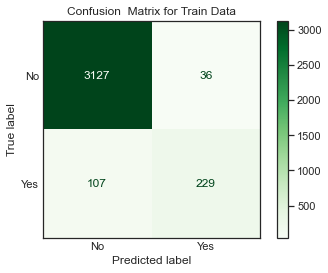

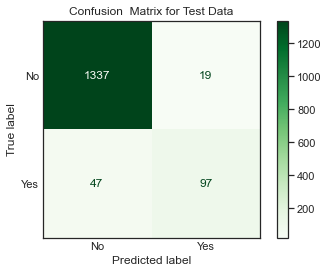

In [79]:
# CCAvg is an important variable as per the Exploratory Data Analysis conducted.
# Hence, we won't be dropping it.

# Checking model performance for this model

scores_statmodel = get_metrics_score(lg3, X_train3, X_test3, Y_train, Y_test, statmodel)
add_score_model(scores_statmodel)

### ROC-AUC Curve on Train data

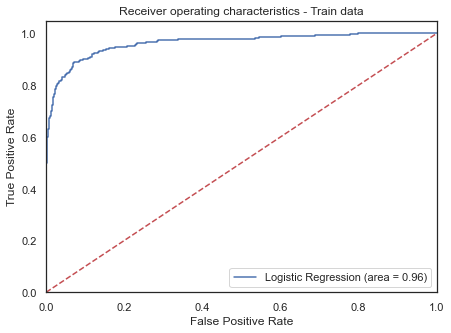

In [80]:
logit_roc_auc_train = roc_auc_score(Y_train, lg3.predict(X_train3))
fpr, tpr, thresholds = roc_curve(Y_train, lg3.predict(X_train3))

plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' %logit_roc_auc_train)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics - Train data')
plt.legend(loc = 'lower right')
plt.show()

### ROC-AUC Curve on Test data

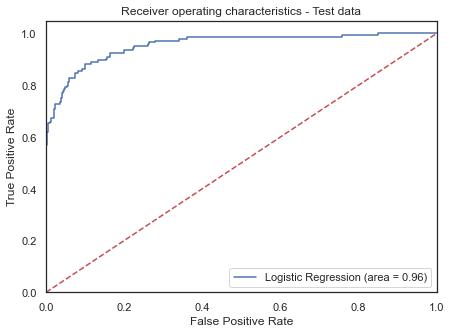

In [81]:
logit_roc_auc_test = roc_auc_score(Y_test, lg3.predict(X_test3))
fpr, tpr, thresholds = roc_curve(Y_test, lg3.predict(X_test3))

plt.figure(figsize = (7, 5))
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' %logit_roc_auc_test)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics - Test data')
plt.legend(loc = 'lower right')
plt.show()

- Logistic Regression is giving a generalized performance on training and test sets.
- ROC-AUC score of 0.96 on training and test sets is quite good.


#### Coefficient Interpretations:
- Coefficient of Income, Education, Family, CCAvg, CDAccount, Age are positive; i.e. a one unit increase in these variables will lead to an increase in chances of a person borrowing a loan.
- Coefficient of SecuritiesAccount, Online, CreditCard are negative; i.e. a one unit increase in these variables will lead to a decrease in the chances of a person borrowing a loan.

### Coverting coefficients to odds

- The coefficients of the logistic regression model are in terms of log(odd); to find the odds, we have to take the exponential of the coefficients.
- Therefore, odds = exp(b)
- Calculate the probability from the odds ratio using the formula; probability = odds / 1 + odds
- The percentage change in odds is given as odds = (exp(b) - 1) * 100

In [82]:
# Calculate the odds ratio, probability
# Create a dataframe to collate odds ratio, probability and p-value of the coefficients

lgcoef = pd.DataFrame(lg3.params, columns = ['coef'])
lgcoef.loc[:, 'Odds Ratio'] = np.exp(lgcoef.coef)
lgcoef['Probability'] = lgcoef['Odds Ratio'] / (1 + lgcoef['Odds Ratio'])
lgcoef['Percentage of Odds'] = (np.exp(lg3.params) - 1) * 100
lgcoef['pval'] = lg3.pvalues
pd.options.display.float_format = '{:.2f}'.format
lgcoef = lgcoef.sort_values(by = 'Odds Ratio', ascending = False)
lgcoef

,coef,Odds Ratio,Probability,Percentage of Odds,pval
Income,3.00,20.14,0.95,1913.74,0.00
Education_3,1.95,7.04,0.88,603.79,0.00
Education_2,1.83,6.25,0.86,525.17,0.00
CDAccount,0.84,2.33,0.70,132.66,0.00
Family,0.77,2.16,0.68,115.78,0.00
CCAvg,0.18,1.20,0.54,19.63,0.05
SecuritiesAccount,-0.23,0.79,0.44,-20.85,0.04
Online,-0.34,0.72,0.42,-28.50,0.00
CreditCard,-0.39,0.68,0.40,-31.98,0.00
const,-5.17,0.01,0.01,-99.43,0.00


- Income: Holding all the other features constant, a one unit change in the Income will increase the odds of the customer taking a personal loan by 20 times or a 95% chance of a customer taking a personal loan.
- Family: Holding all the other features constant, a one unit change in the Family will increase the odds of the customer taking a personal loan by 2.16 times.
- CCAvg: Holding all the other features constant, a one unit change in the CCAvg will increase the odds of the customer taking a personal loan by 1.2 times.
- A customer with Education_3 (Advance) has 7 times higher chances of taking a personal loan than an Undergraduate customer.

- Overall, most significant variables are Income, Education, CDAccount, Family and CCAvg.

### Model performance evaluation and improvement

 Model Performance
 Accuracy   : Train: 0.959  Test:  0.956
 Recall     : Train: 0.682  Test: 0.674
 Precision  : Train: 0.864  Test:  0.836
 F1         : Train: 0.762  Test: 0.746


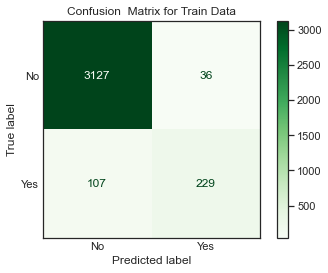

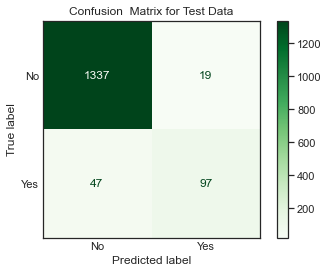

In [83]:
# Checking model performance for this model
scores_statmodel = get_metrics_score(lg3, X_train3, X_test3, Y_train, Y_test, statmodel)

### Insights:

- True Positives: 
    Reality - A customer wanted to take a personal loan. 
    Prediction - The customer will take a personal loan.
    Outcome - The model is good.
    
- True Negatives:
    Reality - A customer did not want to take a personal loan.
    Prediction - The customer will not take a personal loan.
    Outcome - The model is good.
    
- False Positives:
    Reality - A customer did not want to take a personal loan.
    Prediction - The customer will take a personal loan.
    Outcome - The team which is targeting the potential customers would waste tehir resources on the customers who will not be buying a personal loan.
    
- False Negatives:
    Reality - A customer wanted to take a personal loan.
    Prediction - The customer will not take a personal loan.
    Outcome - The potential customer is missed by the sales team. This is a loss of opportunity. The purpose of the campaign was to target such customers. If the team knew about these customers, they could have offered some good APR/interest rates.
    
- Right metric to use:
    Here, not able to identify a potential customer is the biggest loss that we can face. Hence, Recall is the right metric to check the performance of the model. We have Recall as 68 on Train data and 67 on Test data. False Negatives are 107 and 47 on the Train and Test datasets respectively. We can further improve this score using Optimal Threshold for ROC-AUC curve and precision-recall curve.

### Optimal Threshold using ROC-AUC Curve

In [84]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_roc_auc = thresholds[optimal_idx]
print(optimal_threshold_roc_auc)

0.0915012656844664


 Model Performance
 Accuracy   : Train: 0.899  Test:  0.897
 Recall     : Train: 0.902  Test: 0.875
 Precision  : Train: 0.487  Test:  0.481
 F1         : Train: 0.633  Test: 0.621


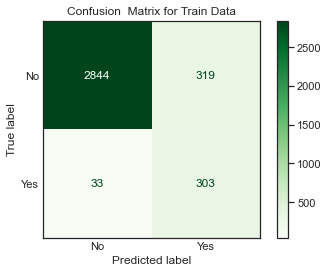

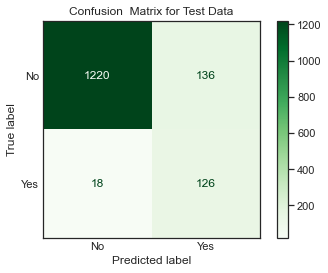

 ROC-AUC Score  :Train::  0.9  Test::  0.887


In [85]:
scores_statmodel = get_metrics_score(lg3, X_train3, X_test3, Y_train, Y_test, statmodel, 
                                    threshold = optimal_threshold_roc_auc, roc = True)
add_score_model(scores_statmodel)

- With 0.092 threshold, the Recall score has improved from 67% to 87.5% on test data with 89% accuracy.
- Also, False Negative values have decreased from 46 to 18 for test data.
- ROC-AUC score is 88.7%, which is really good.


Let's use Precision-Recall curve and see if we can find a better threshold.

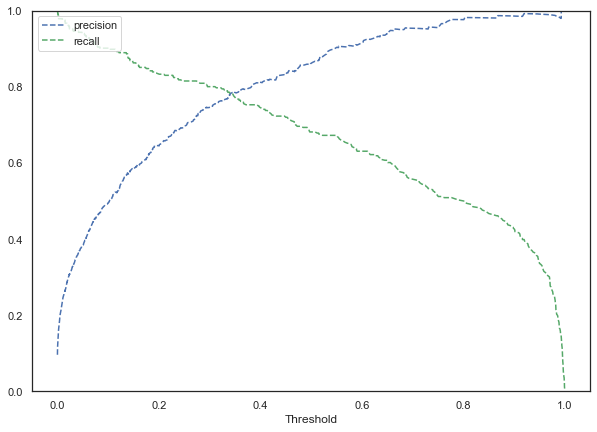

In [86]:
Y_scores = lg3.predict(X_train3)
precision, recall, threshold = precision_recall_curve(Y_train, Y_scores)

def plot_precisionrecall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precision[ : -1], 'b--', label = 'precision')
    plt.plot(thresholds, recall[ : -1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0, 1])
    
plt.figure(figsize = (10, 7))
plot_precisionrecall_vs_threshold(precision, recall, threshold)

 Model Performance
 Accuracy   : Train: 0.955  Test:  0.945
 Recall     : Train: 0.801  Test: 0.729
 Precision  : Train: 0.747  Test:  0.705
 F1         : Train: 0.773  Test: 0.717


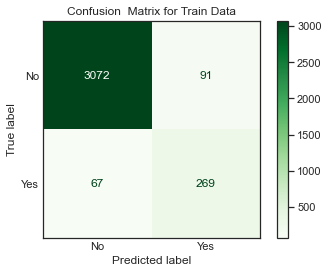

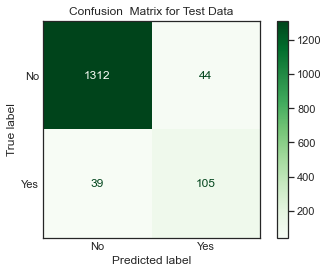

 ROC-AUC Score  :Train::  0.886  Test::  0.848


In [87]:
optimal_threshold_curve = 0.3

scores_optimal_curve = get_metrics_score(lg3, X_train3, X_test3, Y_train, Y_test, statmodel, 
                                        threshold = optimal_threshold_curve, roc = True)
add_score_model(scores_optimal_curve)

- With this model, the False Negative cases have gone up and Recall for test data is ~73% with 94.5% accuracy. The model is performing well on the training and test datasets.
- The model has given a balanced performance, if the bank wishes to maintain a balance between the precision and recall scores, this model can be used.
- Area under the curve has decreased as compared to the initial model but the performance is generalized on training and test datasets.

### Using Sequential Feature Selection

In [88]:
X_train_seq = X_train_stat
X_test_seq = X_test_stat

In [91]:
!pip install mlxtend

  Using cached mlxtend-0.22.0-py2.py3-none-any.whl (1.4 MB)



[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

X_train_seq.shape

(3499, 16)

In [93]:
statmodel = 0

clf = LogisticRegression(solver = 'newton-cg', random_state = 1, fit_intercept = False)

# Building Forward-step Feature Selection
sfs1 = sfs(clf, k_features = 16, forward = True, floating = False, scoring = 'recall', verbose = 2, cv = 5)
sfs1 = sfs1.fit(X_train_seq, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished

[2023-06-08 13:19:56] Features: 1/16 -- score: 0.9941176470588236[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished

[2023-06-08 13:19:57] Features: 2/16 -- score: 0.9970588235294118[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.1s finished

[2023-06-08 13:19:58] Features: 3/16 -- score: 0.9970588235294118[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [94]:
statmodel = 0

clf = LogisticRegression(solver = 'newton-cg', random_state = 1, fit_intercept = False)

# Building Forward-step Feature Selection
sfs1 = sfs(clf, k_features = 11, forward = True, floating = False, scoring = 'recall', verbose = 2, cv = 5)
sfs1 = sfs1.fit(X_train_seq, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.7s finished

[2023-06-08 13:20:09] Features: 1/11 -- score: 0.9941176470588236[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished

[2023-06-08 13:20:10] Features: 2/11 -- score: 0.9970588235294118[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    1.1s finished

[2023-06-08 13:20:11] Features: 3/11 -- score: 0.9970588235294118[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [95]:
# Now, which features are important?
feature_cols = list(sfs1.k_feature_idx_)
print(feature_cols)

[1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14]


In [96]:
X_train_seq.columns[feature_cols]

Index(['Age', 'Income', 'CCAvg', 'Mortgage', 'SecuritiesAccount', 'Online',
       'CreditCard', 'Region_Central', 'Region_Los Angeles Region',
       'Region_Superior', 'Education_2'],
      dtype='object')

In [97]:
# Now, we will fit a sklearn model using these features only
X_train_final = X_train_seq[X_train_seq.columns[feature_cols]]
X_test_final = X_test_seq[X_test_seq.columns[feature_cols]]

 Model Performance
 Accuracy   : Train: 0.677  Test:  0.686
 Recall     : Train: 0.997  Test: 0.972
 Precision  : Train: 0.229  Test:  0.231
 F1         : Train: 0.372  Test: 0.373


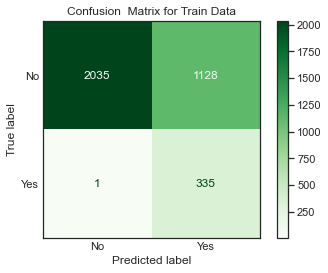

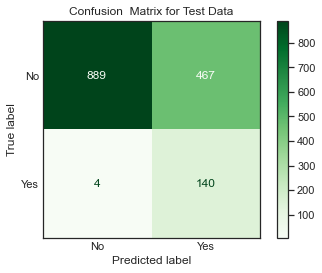

In [98]:
lr = LogisticRegression(solver = 'newton-cg', random_state = 1, fit_intercept = False)
model = lr.fit(X_train_final, Y_train)

statmodel = 0
scores_sfs = get_metrics_score(model, X_train_final, X_test_final, Y_train, Y_test, statmodel)
add_score_model(scores_sfs)

In [99]:
comparison_frame = pd.DataFrame({'Model': ['Logistic Regression Model - Sklearn', 
                                          'Logistic Regression Model - Statmodel', 
                                          'Logistic Regression Optimal Threshold = 0.092', 
                                          'Logistic Regression Optimal Threshold = 0.3', 
                                          'Logistic Regression Sequential Feature Selection'], 
                                'Train Accuracy': acc_train, 
                                'Test Accuracy': acc_test, 
                                'Train Recall': recall_train, 
                                'Test Recall': recall_test, 
                                'Train Precision': precision_train, 
                                'Test Precision': precision_test, 
                                'Train F1': f1_train, 
                                'Test F1': f1_test
                                })

comparison_frame

,Model,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,Train F1,Test F1
0,Logistic Regression Model - Sklearn,0.66,0.65,0.98,0.99,0.22,0.21,0.35,0.35
1,Logistic Regression Model - Statmodel,0.96,0.96,0.68,0.67,0.86,0.84,0.76,0.75
2,Logistic Regression Optimal Threshold = 0.092,0.90,0.90,0.90,0.88,0.49,0.48,0.63,0.62
3,Logistic Regression Optimal Threshold = 0.3,0.95,0.94,0.80,0.73,0.75,0.70,0.77,0.72
4,Logistic Regression Sequential Feature Selection,0.68,0.69,1.00,0.97,0.23,0.23,0.37,0.37


- Since we want higher Recall score, with higher Accuracy, Optimal Threshold = 0.3 seems to be a good choice. 

Lets explore a model with Decision Trees if this score can be improved further.

### Model Building: Decision Trees

1. Data Preparation
2. Partition the data into train and test sets
3. Built a CART model on the train data
4. Tune the model and prune the tree; if required
5. Test the data on the test set

In [100]:
# Dropping columns which we dont need for modelling

df_decision.drop(columns = ['AgeBin', 'ZIPCode', 'County', 'Experience', 'IncomeGroup', 'SpendingGroup'], inplace = True)

In [101]:
X_dt = df_decision.drop('PersonalLoan', axis = 1)
Y_dt = df_decision['PersonalLoan']

In [102]:
oneHotCols = ['Region']
X_dt = pd.get_dummies(X_dt, columns = oneHotCols, drop_first = True)

X_train_dt, X_test_dt, Y_train_dt, Y_test_dt = train_test_split(X_dt, Y_dt, test_size = 0.3, random_state = 1, stratify = Y_dt)

1. We will be using the 'Gini Impurity'
2. If the frequency of a class A is 10% and a class B is 90%, then class B will become the dominant class and the decision tree will become biased towards the dominant class
3. To handle this imbalanced dataset, we can pass a dictionary {0: 0.15, 1: 0.85} to the model to specify the weight of each class and the decision tree will give more weightage to class 1
4. class_weight is a hyperparameter for the decision tree classfier
5. Since, not being able to identify a potential customer is the biggest loss as mentioned earlier; recall is the right metric to check the performance of the model.

In [103]:
def get_recall_score(model):
    Y_train_predict = model.predict(X_train_dt)
    Y_test_predict = model.predict(X_test_dt)
    
    print("\x1b[0;30;47m \033[1mAccuracy : Train :\033[0m", 
          model.score(X_train_dt, Y_train_dt),
          "\x1b[0;30;47m \033[1mTest:\033[0m", 
          model.score(X_test_dt, Y_test_dt))

    print("\x1b[0;30;47m \033[1mRecall   : Train :\033[0m", 
          round(recall_score(Y_train_dt, Y_train_predict), 3),
          "\x1b[0;30;47m \033[1mTest:\033[0m", 
          round(recall_score(Y_test_dt, Y_test_predict), 3))
    
    make_confusion_matrix(Y_train_dt, Y_train_predict, "Confusion Matrix on Training data")
    
    make_confusion_matrix(Y_test_dt, Y_test_predict, "Confusion Matrix on Testing data")

 Accuracy : Train : 1.0  Test: 0.9873333333333333
 Recall   : Train : 1.0  Test: 0.903


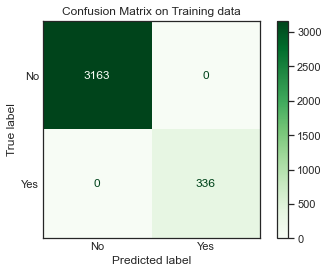

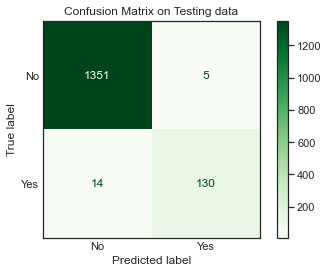

In [104]:
model = DecisionTreeClassifier(criterion = 'gini', class_weight = {0: 0.15, 1: 0.85}, random_state = 1)
model.fit(X_train_dt, Y_train_dt)
get_recall_score(model)

In [105]:
# The Decision Tree tends to overfit and the disparity between Recall on train and test sets suggest that the model is overfitted.

# Let us visualize the decision tree

column_names = list(X_train_dt.columns)
feature_names = column_names
print(feature_names)

['Age', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage', 'SecuritiesAccount', 'CDAccount', 'Online', 'CreditCard', 'Region_Central', 'Region_Los Angeles Region', 'Region_Southern', 'Region_Superior']


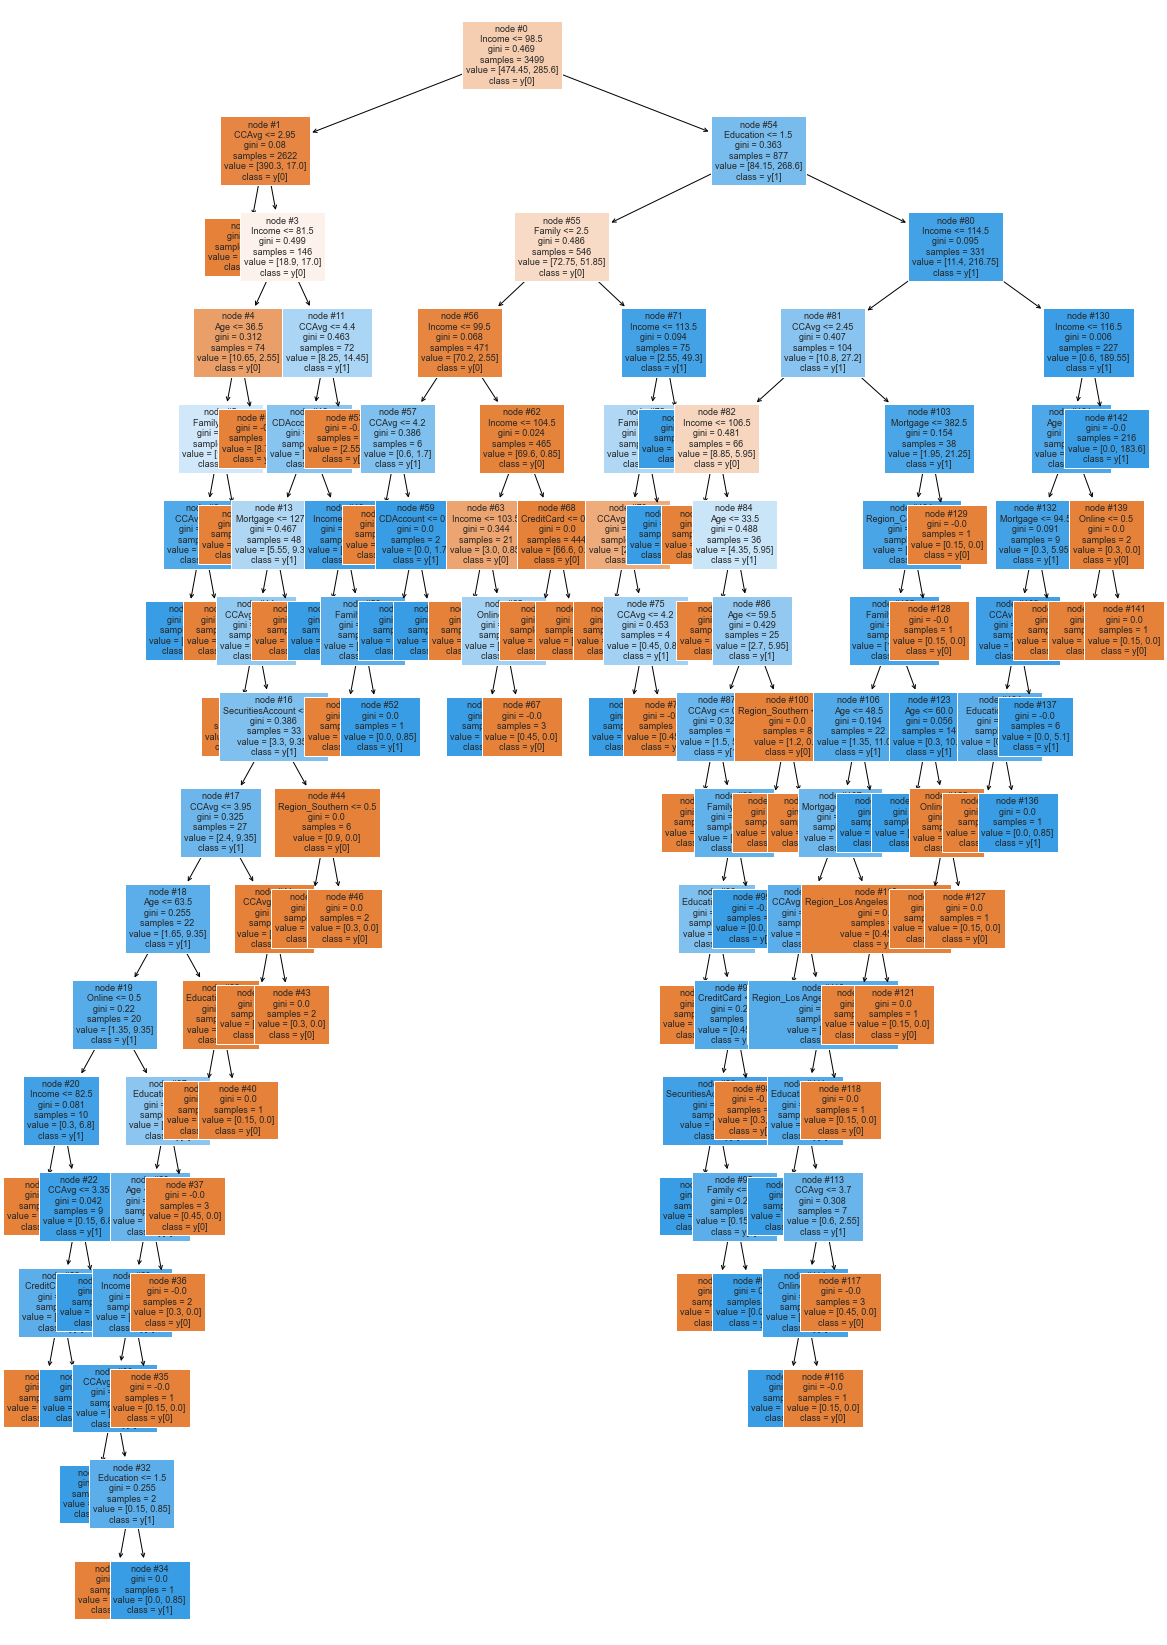

In [106]:
plt.figure(figsize = (20, 30))

from sklearn import tree
from sklearn.model_selection import GridSearchCV

out = tree.plot_tree(model, feature_names = feature_names, filled = True, fontsize = 9, 
                    node_ids = True, class_names = True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [107]:
# Text report showing the rules of the decision tree

print(tree.export_text(model, feature_names = feature_names, show_weights = True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [371.40, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 81.50
|   |   |   |--- Age <= 36.50
|   |   |   |   |--- Family <= 3.50
|   |   |   |   |   |--- CCAvg <= 3.50
|   |   |   |   |   |   |--- weights: [0.00, 2.55] class: 1
|   |   |   |   |   |--- CCAvg >  3.50
|   |   |   |   |   |   |--- weights: [0.30, 0.00] class: 0
|   |   |   |   |--- Family >  3.50
|   |   |   |   |   |--- weights: [1.65, 0.00] class: 0
|   |   |   |--- Age >  36.50
|   |   |   |   |--- weights: [8.70, 0.00] class: 0
|   |   |--- Income >  81.50
|   |   |   |--- CCAvg <= 4.40
|   |   |   |   |--- CDAccount <= 0.50
|   |   |   |   |   |--- Mortgage <= 127.50
|   |   |   |   |   |   |--- CCAvg <= 3.05
|   |   |   |   |   |   |   |--- weights: [0.90, 0.00] class: 0
|   |   |   |   |   |   |--- CCAvg >  3.05
|   |   |   |   |   |   |   |--- SecuritiesAccount <= 0.50
|   |   |   |   |   |   |   |   |--- CCAvg <= 3.95
|   |   |   |   |

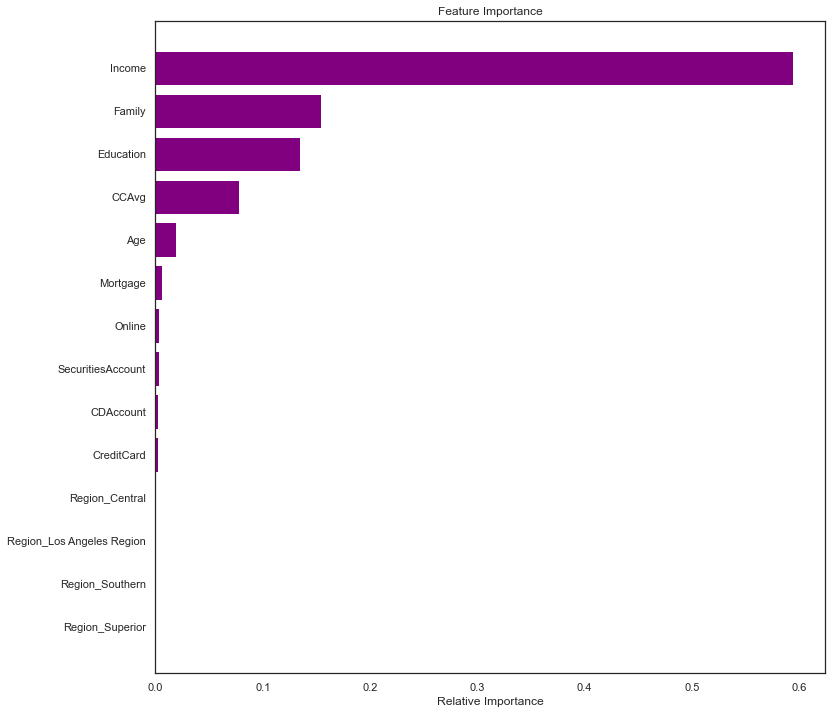

In [108]:
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (12, 12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color = 'purple', align = 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Using GridSearch for hyperparameter tuning of our tree model

1. Grid Search is a tuning technique that attempts to compute the optimum values of hyperparameters
2. It is an exhaustive search that is performed on the specific parameter values of the model
3. The parameters of the model used to apply these methods are optimized by cross-validated grid search over a parameter grid

In [109]:
# Choosing the type of classifier
estimator = DecisionTreeClassifier(random_state = 1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(1, 10), 
             'min_samples_leaf': [1, 2, 5, 7, 10, 15, 20], 
             'max_leaf_nodes': [5, 10, 15, 20, 25, 30]}

# Type of scoring used to compare parameter combinations
import sklearn
acc_scorer = sklearn.metrics.make_scorer(recall_score)

# Running the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring = acc_scorer, cv = 5)
grid_obj = grid_obj.fit(X_train_dt, Y_train_dt)

# Setting the classifier to the best combination of parameters
estimator = grid_obj.best_estimator_
estimator


DecisionTreeClassifier(max_depth=9, max_leaf_nodes=20, random_state=1)

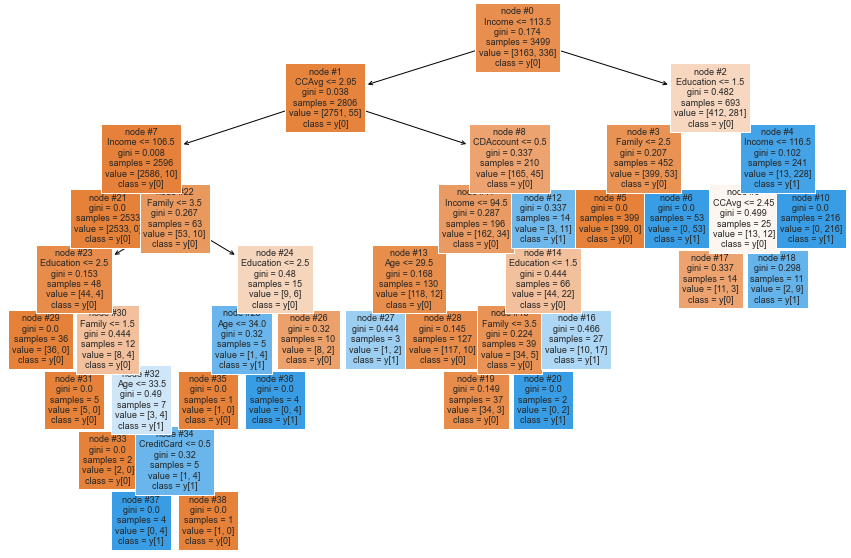

In [110]:
# Fitting the best parameters to the data

estimator.fit(X_train_dt, Y_train_dt)
Y_train_predict = estimator.predict(X_train_dt)
Y_test_predict = estimator.predict(X_test_dt)

plt.figure(figsize = (15, 10))
out = tree.plot_tree(estimator, feature_names = feature_names, filled = True, fontsize = 9, 
                    node_ids = True, class_names = True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

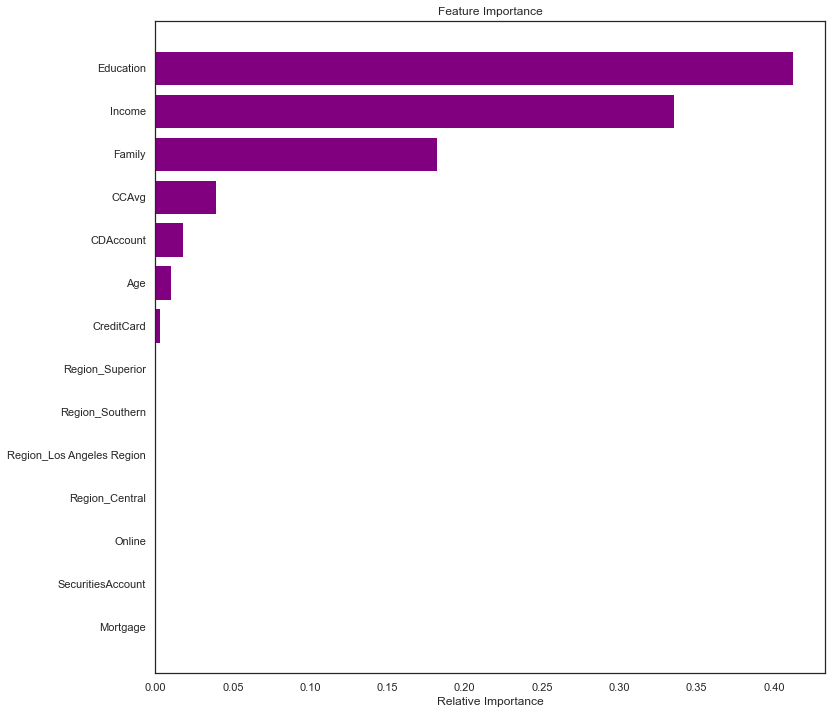

In [111]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (12, 12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color = 'purple', align = 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

 Accuracy : Train : 0.9902829379822806  Test: 0.986
 Recall   : Train : 0.946  Test: 0.931


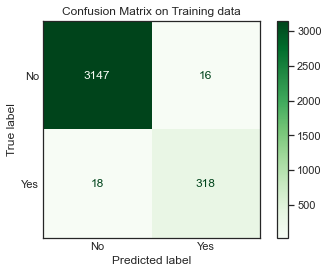

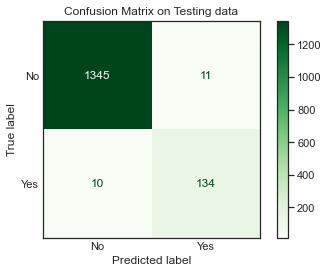

In [112]:
get_recall_score(estimator)

1. With hyperparameters DecisionTreeClassifier(max_depth=9, max_leaf_nodes=20, random_state=1); the overfitting on the train set has reduced. But the recall score for the test dataset has still not improved much.
2. Important features are Education, Income, Family, CCAvg, CDAccount and Age.
3. The recall metric is 0.93 and the false negatives are still 11. We do not wish to lose any opportunity in predicting these customers.

So, instead of pre-pruning, let's see if post-pruning helps in reducing the false negatives.

In [113]:
# Cost complexity pruning

clf = DecisionTreeClassifier(random_state = 1)
path = clf.cost_complexity_pruning_path(X_train_dt, Y_train_dt)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

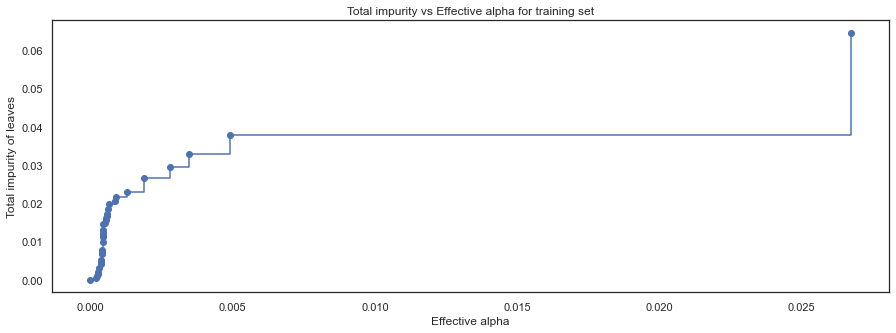

In [114]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(ccp_alphas[: -1], impurities[: -1], marker = 'o', drawstyle = 'steps-post')
ax.set_xlabel('Effective alpha')
ax.set_ylabel('Total impurity of leaves')
ax.set_title('Total impurity vs Effective alpha for training set')
plt.show()

Now, we will train a decision tree using the effective alphas. We will set these values of alpha and pass it to ccp_alpha parameter of our DecisionTreeClassifier. By looping over the alphas array, we will find the accuracy on the training as well as test datasets.

In [115]:
clfs = []
accuracy_train = []
accuracy_test = []
recall_train = []
recall_test = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state = 1, ccp_alpha = ccp_alpha, class_weight = {0: 0.15, 1: 0.85})
    clf.fit(X_train_dt, Y_train_dt)
    Y_train_predict = clf.predict(X_train_dt)
    Y_test_predict = clf.predict(X_test_dt)
    accuracy_train.append(clf.score(X_train_dt, Y_train_dt))
    accuracy_test.append(clf.score(X_test_dt, Y_test_dt))
    recall_train.append(recall_score(Y_train_dt, Y_train_predict))
    recall_test.append(recall_score(Y_test_dt, Y_test_predict))
    clfs.append(clf)

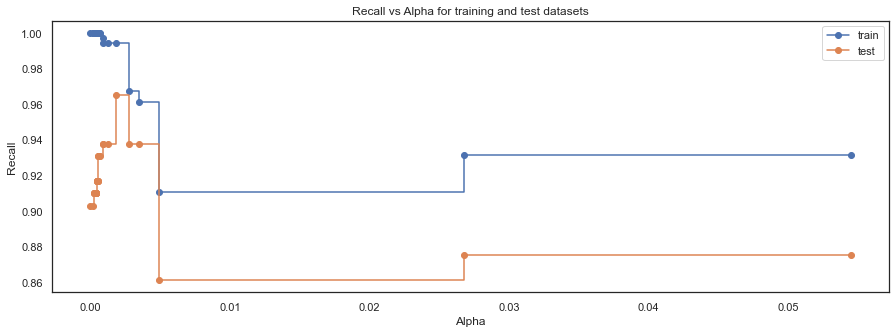

In [116]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(ccp_alphas, recall_train, marker = 'o', label = 'train', drawstyle = 'steps-post')
ax.plot(ccp_alphas, recall_test, marker = 'o', label = 'test', drawstyle = 'steps-post')
ax.set_xlabel('Alpha')
ax.set_ylabel('Recall')
ax.set_title('Recall vs Alpha for training and test datasets')
ax.legend()
plt.show()

In [117]:
# We are getting a higher recall on test data between 0.002 and 0.005. We will choose alpha = 0.002

best_model = DecisionTreeClassifier(ccp_alpha = 0.002, class_weight = {0: 0.15, 1: 0.85}, random_state = 1)
best_model.fit(X_train_dt, Y_train_dt)

DecisionTreeClassifier(ccp_alpha=0.002, class_weight={0: 0.15, 1: 0.85},
                       random_state=1)

 Accuracy : Train : 0.9737067733638183  Test: 0.968
 Recall   : Train : 0.994  Test: 0.965


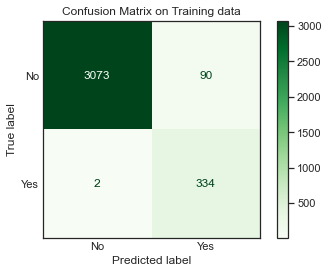

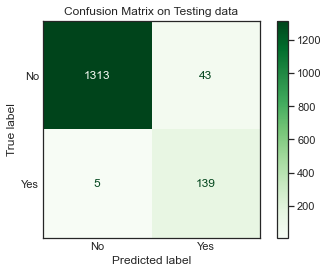

In [118]:
get_recall_score(best_model)

The recall on the train and test datasets indicate that we have created a generalized model; with 96.8% accuracy and reduced false negatives.

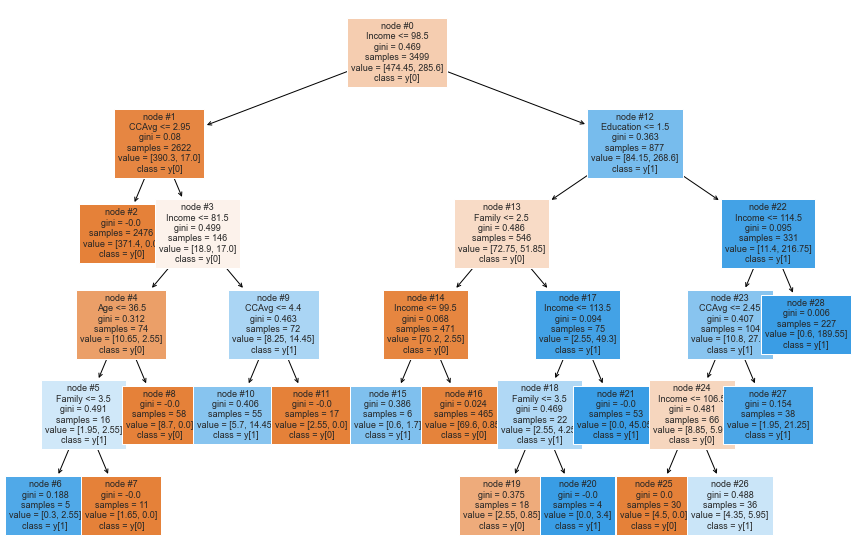

In [119]:
plt.figure(figsize = (15, 10))
out = tree.plot_tree(best_model, feature_names = feature_names, filled = True, fontsize = 9, 
                    node_ids = True, class_names = True)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()

In [120]:
# Text report showing the rules of the decision tree

print(tree.export_text(best_model, feature_names = feature_names, show_weights = True))

|--- Income <= 98.50
|   |--- CCAvg <= 2.95
|   |   |--- weights: [371.40, 0.00] class: 0
|   |--- CCAvg >  2.95
|   |   |--- Income <= 81.50
|   |   |   |--- Age <= 36.50
|   |   |   |   |--- Family <= 3.50
|   |   |   |   |   |--- weights: [0.30, 2.55] class: 1
|   |   |   |   |--- Family >  3.50
|   |   |   |   |   |--- weights: [1.65, 0.00] class: 0
|   |   |   |--- Age >  36.50
|   |   |   |   |--- weights: [8.70, 0.00] class: 0
|   |   |--- Income >  81.50
|   |   |   |--- CCAvg <= 4.40
|   |   |   |   |--- weights: [5.70, 14.45] class: 1
|   |   |   |--- CCAvg >  4.40
|   |   |   |   |--- weights: [2.55, 0.00] class: 0
|--- Income >  98.50
|   |--- Education <= 1.50
|   |   |--- Family <= 2.50
|   |   |   |--- Income <= 99.50
|   |   |   |   |--- weights: [0.60, 1.70] class: 1
|   |   |   |--- Income >  99.50
|   |   |   |   |--- weights: [69.60, 0.85] class: 0
|   |   |--- Family >  2.50
|   |   |   |--- Income <= 113.50
|   |   |   |   |--- Family <= 3.50
|   |   |   |   |   |

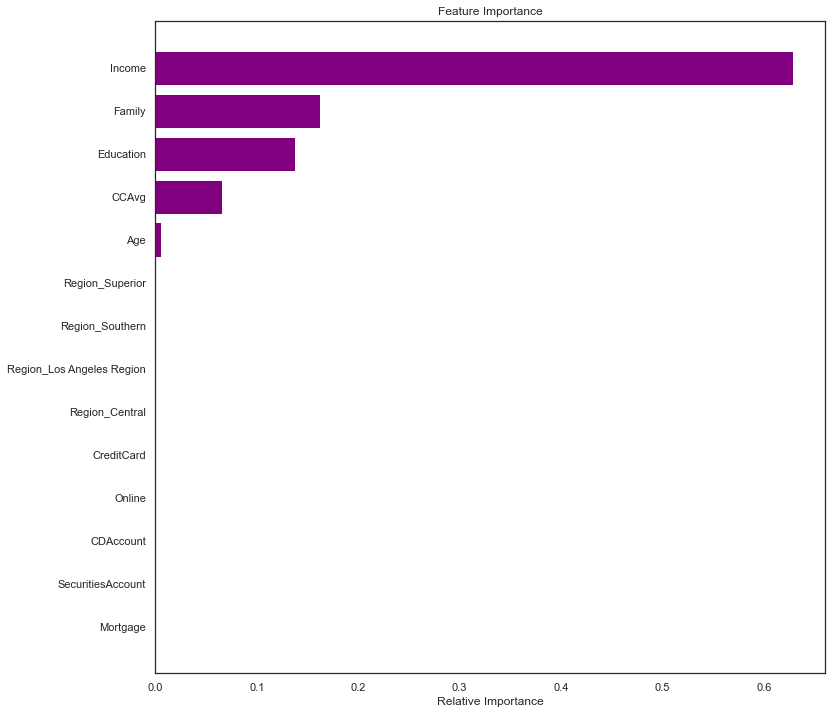

In [121]:
importances = best_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize = (12, 12))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color = 'purple', align = 'center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [122]:
# Comparing all the models based on the performance

comparison_frame = pd.DataFrame({'Model': ['Initial Decision Tree', 'Decision Tree with hyperparameter tuning', 'Decision Tree with post-pruning'], 
                                'Train_accuracy': [1.0, 0.99, 0.98], 
                                'Test_accuracy': [0.98, 0.98, 0.97], 
                                'Train_recall': [1.0, 0.92, 0.98], 
                                'Test_recall': [0.86, 0.84, 0.96]})

comparison_frame

,Model,Train_accuracy,Test_accuracy,Train_recall,Test_recall
0,Initial Decision Tree,1.00,0.98,1.00,0.86
1,Decision Tree with hyperparameter tuning,0.99,0.98,0.92,0.84
2,Decision Tree with post-pruning,0.98,0.97,0.98,0.96


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1356
           1       0.76      0.97      0.85       144

    accuracy                           0.97      1500
   macro avg       0.88      0.97      0.92      1500
weighted avg       0.97      0.97      0.97      1500



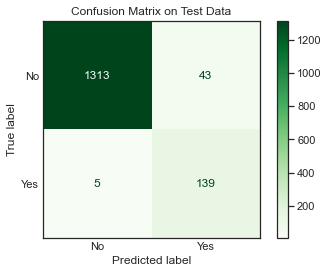

In [123]:
# Choosing Decision Tree with post-pruning for our prediction

Y_predict = best_model.predict(X_test_dt)
print(classification_report(Y_test_dt, Y_predict))
make_confusion_matrix(Y_test_dt, Y_predict, 'Confusion Matrix on Test Data')

### Conclusion

1. We analysed the Personal Loan campaign data using EDA and different versions of the Decision Tree Classifier to predict the likelihood of a customer buying a loan.
2. Decision Trees can easily overfit. They require less data pre-processing compared to Logistic Regression.
3. We used Decision Trees with pre-pruning and post-pruning techniques. The post-pruning model gave 96% recall with 97% accuracy.
4. Income, Family, Education, CCAvg, and Age are important variables in predicting if the customers will buy a personal loan or not.

### Actionable Insights and Recommendations

In [124]:
# Misclassification Analysis

misclass_df = X_test_dt.copy(deep = True)

In [125]:
misclass_df['Actual'] = Y_test_dt
misclass_df['Predicted'] = Y_predict

([<matplotlib.patches.Wedge at 0x22c5b8c34c0>,
 [Text(-1.050350983068654, 0.3267457916587637, ''),
  Text(1.0503509677725784, -0.32674584082924163, '')],
 [Text(-0.5729187180374475, 0.17822497726841657, '90.4%'),
  Text(0.5729187096941336, -0.17822500408867725, '9.6%')])

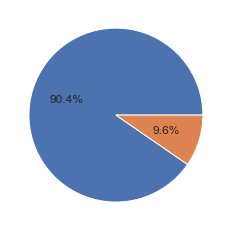

In [126]:
plt.pie(data = misclass_df, x = misclass_df['Actual'].value_counts(), autopct = '%1.1f%%')

([<matplotlib.patches.Wedge at 0x22c5adb6700>,
 [Text(-1.021048935528211, 0.4092176331204549, ''),
  Text(1.0210488972144867, -0.40921772871795375, '')],
 [Text(-0.5569357830153878, 0.22320961806570264, '87.9%'),
  Text(0.5569357621169927, -0.22320967020979296, '12.1%')])

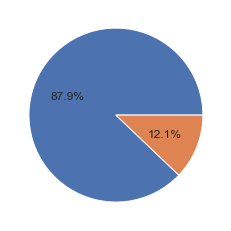

In [127]:
plt.pie(data = misclass_df, x = misclass_df['Predicted'].value_counts(), autopct = '%1.1f%%')

Percentage of 'Yes' predicted by our model is close to the actual value.
Let us find out False Negative and False Positive observations.

In [128]:
pd.crosstab(misclass_df['Predicted'], misclass_df['Actual'], margins = True)

Actual,0,1,All
Predicted,,,
0,1313,5,1318
1,43,139,182
All,1356,144,1500


<AxesSubplot:xlabel='Predicted'>

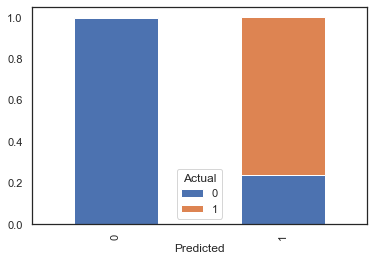

In [129]:
pd.crosstab(misclass_df['Predicted'], misclass_df['Actual'], normalize = 'index').plot(kind = 'bar', stacked = True)

In [130]:
# Rows that were classified as negative when they were actually positive

fn = misclass_df.loc[(misclass_df['Actual'] == 1) & (misclass_df['Predicted'] == 0)]

In [131]:
false_negative = df_decision[df_decision.index.isin(fn.index.values)].copy(deep = True)
false_negative

,Age,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,Region
322,63,101,1,3.90,1,0,1,1,1,1,0,Southern
1069,44,75,2,3.50,1,0,1,0,0,1,0,Los Angeles Region
1518,43,64,4,3.00,3,221,1,0,0,1,0,Bay Area
2623,42,111,3,3.00,1,0,1,1,1,0,1,Bay Area
2996,42,103,1,3.33,1,0,1,1,1,1,1,Los Angeles Region


Our model predicted 5 customers wrongly. Upon analysing the Income, Family, Education and CCAvg, we can see that the income does not fall in the high income group; education is undergrad for most of them; and their monthly average credit card spending is also low. These cases come under exceptions.

In [132]:
# Rows that were classified as positive when they were actually negative

fp = misclass_df.loc[(misclass_df['Actual'] == 0) & (misclass_df['Predicted'] == 1)]

false_positive = df_decision[df_decision.index.isin(fp.index.values)].copy(deep = True)
false_positive

# On analysing education, we can see that most of them are graduates or advanced professionals. These cases come under exceptions.

,Age,Income,Family,CCAvg,Education,Mortgage,PersonalLoan,SecuritiesAccount,CDAccount,Online,CreditCard,Region
82,41,82,1,4.00,3,0,0,0,0,1,0,Southern
85,27,109,4,1.80,3,0,0,0,0,0,0,Bay Area
89,25,113,4,2.30,3,0,0,0,0,0,1,Bay Area
185,39,115,1,1.00,3,0,0,0,0,1,0,Southern
430,51,113,1,1.30,3,161,0,0,0,1,0,Bay Area
515,41,113,1,1.00,3,211,0,0,0,0,1,Southern
621,41,114,2,1.80,2,0,0,0,0,1,0,Los Angeles Region
640,43,85,1,3.70,3,327,0,1,0,1,0,Bay Area
683,40,82,1,3.60,2,0,0,0,0,0,0,Los Angeles Region
731,28,90,2,3.30,1,0,0,0,0,1,1,Los Angeles Region


### Recommendations:

1. Decision Trees do not require data pre-processing or handling of outliers like Logistic Regression. They are easy to understand; but they can easily overfit.
2. Based on EDA and Decision Tree; Income, Family, Education, CCAvg are the most important features.
3. Customers who have incomes greater than 98k USD per annum, a family of more than 2 and/or are graduates or advanced professionals, such customers have higher chances of taking a personal loan.
4. Customer average spending and mortgages can also be looked upon as based on EDA; they also play some role in the likelihood of a customer buying a loan.
5. We can first target high profile customers by providing them with personal relationship managers who can address their concerns and can pursue them to buy a loan with competitive interest rates.
6. Pre-qualifying for loan can also attract more customers.
7. Our second target would be medium profile customers.
8. The model cannot identify well if there are some exceptional cases when low profile customers are ready to buy a personal loan.